In [243]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
from tqdm import tqdm
import re

from collections import Counter
from collections import defaultdict

#### 1. Data Collection

In [244]:
df = pd.read_csv('full_data_stage_1.csv')
df_new = pd.read_excel('data/hh_Russia_30062025.xlsx')
df_new_text = pd.read_excel('data/hh_Russia_text_30062025.xlsx')

In [245]:
# Объединяем 
df_new = df_new.merge(df_new_text[['ID', 'description']], on='ID', how='left')


In [246]:
# Переименовываем 
df_new = df_new.rename(columns={'description': 'text'})

In [247]:
df1 = pd.read_csv('full_data_stage_1.csv')
df1[df1['ID'] == 120336564]

position                      date                          vacancy  \
2444  Аналитик  2025-06-06T16:02:00+0300  Аналитик прогнозирования спроса   

           company    city experience        employment     schedule  \
2444  Русское море  Москва  Нет опыта  Полная занятость  Полный день   

      salary from  salary to  ...                            industry  \
2444     180000.0   180000.0  ...  Рыба и морепродукты (производство)   

                                                   text period of pay  level  \
2444  Обязанности:\n \n \nЗапуск и управление процес...           NaN    NaN   

     responsibilities requirements education  benefits  contacts  contact  
2444              NaN          NaN       NaN       NaN       NaN      NaN  

[1 rows x 25 columns]

In [248]:
# Сколько ID, есть в df_new, но отсутствуют в df
new_ids = df_new[~df_new['ID'].isin(df['ID'])]['ID']

new_ids.count()

np.int64(34460)

In [249]:
# Находим ID, которые есть в df_new, но отсутствуют в df
new_ids = df_new[~df_new['ID'].isin(df['ID'])]['ID']

# Выбираем строки из df_new с этими ID и добавляем их в df
df = pd.concat([df, df_new[df_new['ID'].isin(new_ids)]], ignore_index=True)

In [250]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53152 entries, 0 to 53151
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   position          53152 non-null  object 
 1   date              53152 non-null  object 
 2   vacancy           53152 non-null  object 
 3   company           53152 non-null  object 
 4   city              53152 non-null  object 
 5   experience        51858 non-null  object 
 6   employment        53152 non-null  object 
 7   schedule          53152 non-null  object 
 8   salary from       26511 non-null  float64
 9   salary to         23480 non-null  float64
 10  currency          27567 non-null  object 
 11  skills            31429 non-null  object 
 12  url               53152 non-null  object 
 13  ID                53137 non-null  float64
 14  country           1294 non-null   object 
 15  industry          51843 non-null  object 
 16  text              52954 non-null  object

In [251]:

df = df.drop_duplicates(subset=['text'])

In [252]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45531 entries, 0 to 53151
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   position          45531 non-null  object 
 1   date              45531 non-null  object 
 2   vacancy           45531 non-null  object 
 3   company           45531 non-null  object 
 4   city              45531 non-null  object 
 5   experience        44271 non-null  object 
 6   employment        45531 non-null  object 
 7   schedule          45531 non-null  object 
 8   salary from       21595 non-null  float64
 9   salary to         19715 non-null  float64
 10  currency          22369 non-null  object 
 11  skills            26789 non-null  object 
 12  url               45531 non-null  object 
 13  ID                45530 non-null  float64
 14  country           1260 non-null   object 
 15  industry          44270 non-null  object 
 16  text              45530 non-null  object 
 17

##### 1.1. Data collection- Skills

In [253]:
# Берем строки где нет Skliis , но есть текст и хотябы одно поле с зарплатой
no_skills = (df[(df['skills'].isna()) & (~df['text'].isna()) & (~df['salary to'].isna() | ~df['salary from'].isna())][['text','ID']])
no_skills.shape

(8187, 2)

In [254]:
# это после идеи Шахена - перепроверить скилы хх ибо там мало по сравнению с описанием 
# Создаем маску для строк, которые НЕ нужно повторно проверять через Мистрал  (те, чьих ID нет в no_skills)
mask = ~df['ID'].isin(no_skills['ID'])

# Создаем новый DataFrame без этих строк
df_to_mistral_skills = df[mask].copy()

In [255]:
df_to_mistral_skills.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37344 entries, 0 to 53151
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   position          37344 non-null  object 
 1   date              37344 non-null  object 
 2   vacancy           37344 non-null  object 
 3   company           37344 non-null  object 
 4   city              37344 non-null  object 
 5   experience        36522 non-null  object 
 6   employment        37344 non-null  object 
 7   schedule          37344 non-null  object 
 8   salary from       13717 non-null  float64
 9   salary to         12450 non-null  float64
 10  currency          14182 non-null  object 
 11  skills            26789 non-null  object 
 12  url               37344 non-null  object 
 13  ID                37343 non-null  float64
 14  country           822 non-null    object 
 15  industry          36521 non-null  object 
 16  text              37343 non-null  object 
 17

In [256]:
df_to_mistral_skills.shape

(37344, 25)

In [257]:
#df_to_mistral_skills.to_csv('hh_skills_to_check_2.csv')

In [258]:
duplicates_text = no_skills[no_skills.duplicated(subset=['text'], keep=False)]
duplicates_text.shape

(0, 2)

In [259]:
# Сохраним для обработки через Mistral 

#no_skills.to_csv('hh_text.csv')

In [260]:
#no_skills

In [261]:
# Загрузим результат обработки

df_skills = pd.read_csv('hh_text_skills_mistral.csv')

In [262]:
df_skills = df_skills.rename(columns={'salary_from': 'salary from', 'salary_to': 'salary to'})

In [263]:

# Объединение по ID
df_updated = df.merge(df_skills, on='ID', how='left', suffixes=('', '_new'))

# 1. Обновление skills только для строк, отфильтрованных ранее
no_skills_ids = df[(df['skills'].isna()) & (~df['text'].isna()) & (~df['salary to'].isna() | ~df['salary from'].isna())]['ID']
df_updated.loc[df_updated['ID'].isin(no_skills_ids), 'skills'] = df_updated.loc[df_updated['ID'].isin(no_skills_ids), 'skills_new']

# 2. Обновление только тех полей, которые отсутствуют в оригинальном df
fields_to_update = ['experience', 'schedule', 'salary from', 'salary to', 'currency', 'responsibilities', 'requirements']
for field in fields_to_update:
    df_updated[field] = df_updated[field].combine_first(df_updated[f'{field}_new'])


# 4. Удаление всех *_new и Unnamed: 0
cols_to_drop = [col for col in df_updated.columns if col.endswith('_new') or col == 'Unnamed: 0']
df_updated.drop(columns=cols_to_drop, inplace=True)

In [264]:
df_updated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45531 entries, 0 to 45530
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   position          45531 non-null  object 
 1   date              45531 non-null  object 
 2   vacancy           45531 non-null  object 
 3   company           45531 non-null  object 
 4   city              45531 non-null  object 
 5   experience        44495 non-null  object 
 6   employment        45531 non-null  object 
 7   schedule          45531 non-null  object 
 8   salary from       21615 non-null  float64
 9   salary to         19742 non-null  float64
 10  currency          22369 non-null  object 
 11  skills            34470 non-null  object 
 12  url               45531 non-null  object 
 13  ID                45530 non-null  float64
 14  country           1260 non-null   object 
 15  industry          44270 non-null  object 
 16  text              45530 non-null  object

In [265]:
df_copy = df.copy()
df = df_updated

##### 1.2. Data collection- Salary

In [266]:
df_no_salary = df[(df['salary to'].isna()) & (df['salary from'].isna())][['ID', 'text']]

In [267]:
df_no_salary.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23162 entries, 16381 to 45530
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      23162 non-null  float64
 1   text    23162 non-null  object 
dtypes: float64(1), object(1)
memory usage: 542.9+ KB


In [268]:
#df_no_salary.to_csv('df_no_salary.csv')

In [269]:
temp = pd.read_csv('output_partial.csv')
display(temp.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23162 entries, 0 to 23161
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   23162 non-null  int64  
 1   ID           23162 non-null  float64
 2   text         23162 non-null  object 
 3   salary_from  96 non-null     float64
 4   salary_to    33 non-null     float64
dtypes: float64(3), int64(1), object(1)
memory usage: 904.9+ KB


None

In [270]:
with pd.option_context('display.max_rows', 200):
    display(temp[~temp['salary_from'].isna()])

Unnamed: 0           ID  \
407         16832  121434372.0   
408         16833  121434362.0   
722         17184  122093767.0   
1082        17582  122034442.0   
1545        18107  119238290.0   
1554        18130  121437066.0   
1661        18269  120272229.0   
1818        18458  121458426.0   
2297        19025  121872607.0   
2476        19232  121389575.0   
3416        20321  118910628.0   
3650        20618  121373633.0   
3663        20632  121306793.0   
3924        20928  121518113.0   
5360        22749  121485642.0   
5545        23134  121696722.0   
5637        23282  120749668.0   
5756        23538  122136861.0   
5957        23808  122213042.0   
5997        23867  121357626.0   
6472        24416  121695310.0   
6522        24480  121876715.0   
6872        24900  121436205.0   
6970        25014  121216672.0   
7008        25056  122219059.0   
7429        25543  120826349.0   
7769        25938  122184573.0   
7781        25962  122102964.0   
7783        25965  122088571.0   
7817        26021  121354178.0   
7818        26022  121354172.0   
7819        26023  121354168.0   
7968        26226  121384730.0   
8251        26584  121417984.0   
8291        26626  121273050.0   
9328        27828  121711772.0   
9663        28297  121851698.0   
9807        28484  121666987.0   
10254       29003  119120327.0   
10432       29237  121447287.0   
10854       29735  121898176.0   
10862       29744  121429458.0   
10956       29862  119647167.0   
11075       30022  120453664.0   
11076       30024  106568911.0   
11464       30525  121213756.0   
11465       30526  121213702.0   
11486       30564  117801181.0   
11487       30565  121696256.0   
12306       31566  109652555.0   
12386       31662  120779068.0   
12446       31742  121758770.0   
12909       32286  121508298.0   
13185       32591  121420672.0   
13206       32612  121503077.0   
13439       32884  121380609.0   
13622       33090  119682974.0   
13695       33184  122219085.0   
13967       33524  122105353.0   
14758       34572  121489361.0   
15361       35350  121445897.0   
15377       35387  122115844.0   
15981       36167  121692666.0   
16911       37547  122069318.0   
16915       37552  121091006.0   
17618       38445  121835609.0   
17938       38805  121320735.0   
17964       38832  120336863.0   
18125       39013  121793050.0   
18415       39330  121570159.0   
19211       40227  120220350.0   
19327       40351  120627959.0   
19379       40413  121571300.0   
19544       40631  121210644.0   
19741       40886  121806822.0   
20049       41246  121309057.0   
20134       41429  121571154.0   
20181       41509  121694140.0   
20186       41524  121896336.0   
20187       41525  121895991.0   
20203       41554  114977961.0   
20204       41555  114977714.0   
20455       41956  121816361.0   
20738       42372  122003142.0   
20864       42575  121268982.0   
20876       42601  121520554.0   
21178       43071  119475487.0   
21179       43072  119475347.0   
21211       43162  121858238.0   
21855       43982  121948131.0   
22541       44789  121872483.0   
22559       44811  121569818.0   
22561       44813  121569834.0   
22564       44816  121434427.0   
22630       44889  122069342.0   
23156       45524  122099103.0   

                                                    text  salary_from  \
407    О команде:\n \nХочешь начать карьеру в престиж...      80000.0   
408    О команде:\n \nКоманда развития корпоративного...      80000.0   
722    Описание:\n Компания «ANCOR», лидер кадрового ...      70000.0   
1082   Кто сказал, что нужен опыт? Мы ценим твой поте...      70000.0   
1545   Центральный офис компании «Первый Бит»\n - одн...     100000.0   
1554   Набираем на БЕСПЛАТНОЕ обучение начинающих спе...      20000.0   
1661   Группа компаний «СофтБаланс»\n - системный инт...      90000.0   
1818   РУМИКОН\n – команда профессионалов, которые лю...     200000.0   
2297   Мы предлагаем возможность пройти 3х месячную

In [271]:
df_no_salary = pd.read_csv('df_no_salary_mistral.csv')

In [272]:
df_no_salary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23162 entries, 0 to 23161
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   23162 non-null  int64  
 1   ID           23162 non-null  float64
 2   text         23162 non-null  object 
 3   salary_from  96 non-null     float64
 4   salary_to    33 non-null     float64
dtypes: float64(3), int64(1), object(1)
memory usage: 904.9+ KB


In [273]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45531 entries, 0 to 45530
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   position          45531 non-null  object 
 1   date              45531 non-null  object 
 2   vacancy           45531 non-null  object 
 3   company           45531 non-null  object 
 4   city              45531 non-null  object 
 5   experience        44495 non-null  object 
 6   employment        45531 non-null  object 
 7   schedule          45531 non-null  object 
 8   salary from       21615 non-null  float64
 9   salary to         19742 non-null  float64
 10  currency          22369 non-null  object 
 11  skills            34470 non-null  object 
 12  url               45531 non-null  object 
 13  ID                45530 non-null  float64
 14  country           1260 non-null   object 
 15  industry          44270 non-null  object 
 16  text              45530 non-null  object

In [274]:

# Оставляем только строки, где заполнено хотя бы одно поле зарплаты
filtered = df_no_salary.dropna(subset=['salary_from', 'salary_to'], how='all')

# Переименовываем колонки (если нужно)
filtered = filtered.rename(columns={
    'salary_from': 'salary from',
    'salary_to': 'salary to'
})

# Создаем маску для строк, где в основном df отсутствуют оба значения зарплаты
mask = df['ID'].isin(filtered['ID']) & (df['salary from'].isna() | df['salary to'].isna())

# Обновляем ТОЛЬКО пропущенные значения (если в filtered есть данные)
df.loc[mask, ['salary from', 'salary to']] = (
    filtered.set_index('ID')
    .loc[df.loc[mask, 'ID']]  # Берем только нужные ID
    [['salary from', 'salary to']]  # Выбираем только нужные колонки
    .values
)

##### 1.3. Data collection- Country

In [275]:
#df.to_csv('df_city_country.csv')

In [276]:
df_no_country = pd.read_csv('df_city_country.csv') 

In [277]:
df_no_country.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22472 entries, 0 to 22471
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        22472 non-null  int64  
 1   position          22472 non-null  object 
 2   date              22472 non-null  object 
 3   vacancy           22472 non-null  object 
 4   company           22472 non-null  object 
 5   city              22472 non-null  object 
 6   experience        22277 non-null  object 
 7   employment        22472 non-null  object 
 8   schedule          22472 non-null  object 
 9   salary from       21711 non-null  float64
 10  salary to         19775 non-null  float64
 11  currency          22369 non-null  object 
 12  skills            21915 non-null  object 
 13  url               22472 non-null  object 
 14  ID                22471 non-null  float64
 15  country           22467 non-null  object 
 16  industry          21211 non-null  object

In [278]:
# Оставляем только строки, где country не NaN 
filtered = df_no_country.dropna(subset=['country'])

# Маска: 
# 1) ID есть в filtered
# 2) В df country — пустое (чтобы не перезаписывать существующие данные)
mask = df['ID'].isin(filtered['ID']) & df['country'].isna()

# Обновляем country в df, используя данные из df_no_country_filtered
df.loc[mask, 'country'] = (
    filtered.set_index('ID')
    .loc[df.loc[mask, 'ID'], 'country']
    .values
)

In [279]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45531 entries, 0 to 45530
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   position          45531 non-null  object 
 1   date              45531 non-null  object 
 2   vacancy           45531 non-null  object 
 3   company           45531 non-null  object 
 4   city              45531 non-null  object 
 5   experience        44495 non-null  object 
 6   employment        45531 non-null  object 
 7   schedule          45531 non-null  object 
 8   salary from       21711 non-null  float64
 9   salary to         19775 non-null  float64
 10  currency          22369 non-null  object 
 11  skills            34470 non-null  object 
 12  url               45531 non-null  object 
 13  ID                45530 non-null  float64
 14  country           22467 non-null  object 
 15  industry          44270 non-null  object 
 16  text              45530 non-null  object

##### 1.4. Data collection- Experience

In [280]:
# Пропусков мало , опробуем просто отсечь пустыми salary

# Удаляем строки, где обе пустые
cleaned_data = df.dropna(subset=['salary from', 'salary to'], how='all')


In [281]:
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22472 entries, 0 to 45527
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   position          22472 non-null  object 
 1   date              22472 non-null  object 
 2   vacancy           22472 non-null  object 
 3   company           22472 non-null  object 
 4   city              22472 non-null  object 
 5   experience        21436 non-null  object 
 6   employment        22472 non-null  object 
 7   schedule          22472 non-null  object 
 8   salary from       21711 non-null  float64
 9   salary to         19775 non-null  float64
 10  currency          22369 non-null  object 
 11  skills            21915 non-null  object 
 12  url               22472 non-null  object 
 13  ID                22471 non-null  float64
 14  country           22467 non-null  object 
 15  industry          21211 non-null  object 
 16  text              22471 non-null  object 
 17

In [282]:
cleaned_data['experience'].value_counts(dropna=False)

experience
1–3 года                               11228
3–6 лет                                 5619
Нет опыта                               3588
NaN                                     1036
Более 6 лет                              777
                                       ...  
Рассматриваем с опытом в маркетинге        1
не менее года                              1
от 4 лет                                   1
2+ years                                   1
4–5 лет                                    1
Name: count, Length: 100, dtype: int64

In [283]:
#  не вышло , закидываем в мистрал строки с непустыми text
df_copy = df.copy()
df = cleaned_data

In [284]:
mask = (df['experience'].isna() & ~df['text'].isna())

df[mask].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1036 entries, 2 to 1260
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   position          1036 non-null   object 
 1   date              1036 non-null   object 
 2   vacancy           1036 non-null   object 
 3   company           1036 non-null   object 
 4   city              1036 non-null   object 
 5   experience        0 non-null      object 
 6   employment        1036 non-null   object 
 7   schedule          1036 non-null   object 
 8   salary from       1036 non-null   float64
 9   salary to         1036 non-null   float64
 10  currency          1036 non-null   object 
 11  skills            1018 non-null   object 
 12  url               1036 non-null   object 
 13  ID                1036 non-null   float64
 14  country           1036 non-null   object 
 15  industry          0 non-null      object 
 16  text              1036 non-null   object 
 17  

In [285]:
# проверим на пустые не Nan
df[(df['experience'] == '') | (df['experience'] == ' ')]

Empty DataFrame
Columns: [position, date, vacancy, company, city, experience, employment, schedule, salary from, salary to, currency, skills, url, ID, country, industry, text, period of pay, level, responsibilities, requirements, education, benefits, contacts, contact, experience level]
Index: []

[0 rows x 26 columns]

In [286]:
# сохраняем и отправляем в мистрал 
#df[mask].to_csv('df_to_ml_experience.csv')

In [287]:
df_exp = pd.read_csv('df_to_ml_experience.csv')

# 1. Оставляем только строки, где experience заполнен
df_exp = df_exp.dropna(subset=['experience'])

# 2. Создаем маску для строк, которые нужно обновить в основном df:
#    - ID есть в обработанных данных
#    - experience в основном df был пустым
mask = df['ID'].isin(df_exp['ID']) & df['experience'].isna()

# 3. Обновляем experience в основном DataFrame
df.loc[mask, 'experience'] = (
    df_exp.set_index('ID')
    .loc[df.loc[mask, 'ID'], 'experience']
    .values
)

In [288]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22472 entries, 0 to 45527
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   position          22472 non-null  object 
 1   date              22472 non-null  object 
 2   vacancy           22472 non-null  object 
 3   company           22472 non-null  object 
 4   city              22472 non-null  object 
 5   experience        21579 non-null  object 
 6   employment        22472 non-null  object 
 7   schedule          22472 non-null  object 
 8   salary from       21711 non-null  float64
 9   salary to         19775 non-null  float64
 10  currency          22369 non-null  object 
 11  skills            21915 non-null  object 
 12  url               22472 non-null  object 
 13  ID                22471 non-null  float64
 14  country           22467 non-null  object 
 15  industry          21211 non-null  object 
 16  text              22471 non-null  object 
 17

In [289]:
df[df['country'].isna()]['city']

35603           Африканда
40559        Богатые Сабы
40560        Богатые Сабы
40563    Григорополисская
42993            Кшенский
Name: city, dtype: object

In [290]:
df_copy = df.copy()

#### 2. Data Cleaning + Data Preparation

In [291]:
# дубликаты
columns_to_check = [col for col in df_copy.columns if col != 'date']
duplicates = df_copy[df_copy.duplicated(subset=columns_to_check, keep='first')]
print(f"Найдено дубликатов: {len(duplicates)}")

Найдено дубликатов: 0


In [292]:
# Удалим строки с пустыми признаками 

df_copy = df_copy.dropna(subset=['experience', 'country','skills'],  how='any')

In [293]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21032 entries, 0 to 45527
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   position          21032 non-null  object 
 1   date              21032 non-null  object 
 2   vacancy           21032 non-null  object 
 3   company           21032 non-null  object 
 4   city              21032 non-null  object 
 5   experience        21032 non-null  object 
 6   employment        21032 non-null  object 
 7   schedule          21032 non-null  object 
 8   salary from       20277 non-null  float64
 9   salary to         18418 non-null  float64
 10  currency          20980 non-null  object 
 11  skills            21032 non-null  object 
 12  url               21032 non-null  object 
 13  ID                21031 non-null  float64
 14  country           21032 non-null  object 
 15  industry          20687 non-null  object 
 16  text              21031 non-null  object 
 17

In [294]:
#df_copy.to_csv('data/stage_3_full_data.csv', index = False)

In [295]:
df_copy = pd.read_csv('data/stage_3_full_data.csv')

In [296]:
mask = (df_copy['salary from'] < 10000) | (df_copy['salary to'] < 10000)
df_copy[mask].shape

(190, 26)

In [297]:
df = df_copy

In [298]:
# присоединяем скилы , что набрал через llm

In [299]:
df_skills_2 = pd.read_csv('hh_skills_checked_2.csv')

# Переименуем колонку 'skills' в 'skills_llm' в df_skills_2
df_skills_2 = df_skills_2.rename(columns={'skills_y': 'skills_llm'})

# Объединение по 'ID' (left join, чтобы сохранить все строки из df)
df = df.merge(df_skills_2[['ID', 'skills_llm']], on='ID', how='left')

##### 2.1 Skills

In [300]:
# Создадим признак skills_new. Возьмем за основу то что сделала LLM а в пустые заполним значения из skills

df['skills_new'] = df['skills_llm'].combine_first(df['skills'])

In [301]:
# Преобразование skills в список 

from ast import literal_eval

def convert_to_list(value):
    if isinstance(value, list):  # Если уже список - возвращаем как есть
        return value
    try:
        # Пробуем распарсить строку как список (если формат подходящий)
        return literal_eval(str(value))
    except (ValueError, SyntaxError):
        # Если не получается - разбиваем по запятым
        return [s.strip() for s in str(value).split(',') if s.strip()]

# Применяем функцию ко всем значениям столбца skills
df['skills_list'] = df['skills_new'].apply(convert_to_list)

In [302]:
# Функция для очистки пустых списков
def clean_skills(skill_data):
    if isinstance(skill_data, list):
        if len(skill_data) == 0:  # Пустой список []
            return np.nan
        if len(skill_data) == 1 and isinstance(skill_data[0], list) and len(skill_data[0]) == 0:  # Список с пустым списком [[]]
            return np.nan
    return skill_data

# Применяем очистку
df['skills_list'] = df['skills_list'].apply(clean_skills)

In [303]:

# 1. Преобразуем все skills в плоский список отдельных навыков
def flatten_skills(skills_series):
    all_skills = []
    for skill_list in skills_series:
        if isinstance(skill_list, list):
            all_skills.extend(skill_list)
    return all_skills


# 2. Собираем все навыки в один список
all_skills = flatten_skills(df['skills_list'])

# 3. Подсчет уникальных навыков
unique_skills_count = len(set(all_skills))  # Количество уникальных навыков
skills_frequency = Counter(all_skills)      # Частота каждого навыка

print(f"Общее количество уникальных навыков: {unique_skills_count}")

# 4. Топ-20 самых популярных навыков
top_skills = pd.DataFrame.from_dict(skills_frequency, orient='index', columns=['Количество'])
top_skills = top_skills.sort_values('Количество', ascending=False).head(50)

print("\nТоп-20 самых популярных навыков:")
print(top_skills)

Общее количество уникальных навыков: 64857

Топ-20 самых популярных навыков:
                        Количество
SQL                           1406
1С                            1192
Linux                         1074
PostgreSQL                    1045
Python                        1011
Git                           1005
Docker                         895
Excel                          821
Figma                          789
Adobe Photoshop                711
MS Office                      606
JavaScript                     600
Adobe Illustrator              596
MySQL                          552
HTML                           527
PHP                            514
DNS                            495
Photoshop                      489
CSS                            488
DHCP                           434
Windows                        433
REST API                       429
Zabbix                         420
TCP/IP                         416
Jira                           412
Redis        

In [304]:
def normalize_skills(raw):
    if raw is None or (isinstance(raw, float) and np.isnan(raw)):
        return None

    if isinstance(raw, np.ndarray):
        raw = raw.tolist()

    # Раскрытие вложенных списков
    flattened = []
    for item in raw:
        if isinstance(item, list):
            flattened.extend(item)
        else:
            flattened.append(item)

    # Очистка каждого скилла
    cleaned = []
    for skill in flattened:
        skill = str(skill).strip()

        # 💥 Удаляем любые кавычки или скобки по краям
        skill = re.sub(r"^[\[\]\"']+|[\[\]\"']+$", "", skill).strip()

        if skill:
            cleaned.append(skill) #.lower()

    return cleaned

In [305]:
def clean_skill(skill):
    # Удаляем одиночные/незакрытые скобки и пробелы
    skill = re.sub(r'\(\s*', '', skill)  # удаляем '(' без пары
    skill = re.sub(r'\s*\)', '', skill)  # удаляем ')' без пары
    return skill.strip()

def clean_skills_list(skills_list):
    if not isinstance(skills_list, list):
        return []
    return [clean_skill(skill) for skill in skills_list]

In [306]:
df['skills_clean'] = df['skills_list'].apply(normalize_skills)
df['skills_clean'] = df['skills_clean'].apply(clean_skills_list)

In [307]:
all_skills = flatten_skills(df['skills_clean'])
unique_skills_count = len(set(all_skills))
display(unique_skills_count)

64706

In [308]:
# почистим от артефактов

def clean_skill(skill):
    # Паттерн для ненужных символов в начале и конце 
    
    pattern = r'^[\s•\-;.]+|[\s•\-;.]+$'
    
    # Удаляем лишние символы, но не трогаем корректные точки/дефисы внутри названия
    cleaned = re.sub(pattern, '', str(skill).strip())
    
    # Удаляем двойные пробелы, оставшиеся после очистки
    cleaned = re.sub(r'\s+', ' ', cleaned)
    
    
    return cleaned

cleaned_skills = [clean_skill(skill) for skill in all_skills]

print(len(list(set(cleaned_skills))))

64696


In [309]:
df['skills_clean'] = df['skills_clean'].apply(
    lambda skills: [clean_skill(skill) for skill in skills] if isinstance(skills, list) else skills)

In [310]:
# проверим на пустые 

def clean_empty_skills(df, column='skills_clean'):

    # Условия "пустоты"
    is_nan_or_none = df[column].isna()
    is_empty_string = df[column].apply(lambda x: isinstance(x, str) and x.strip() == '')
    is_empty_list = df[column].apply(lambda x: isinstance(x, list) and len(x) == 0)

    # Объединяем все условия
    empty_mask = is_nan_or_none | is_empty_string | is_empty_list
    num_empty = empty_mask.sum()

    print(f"Найдено пустых значений в '{column}': {num_empty}")

    # Удаляем строки
    df_cleaned = df[~empty_mask].reset_index(drop=True)
    print(f"После очистки: {len(df_cleaned)} строк осталось")

    return df_cleaned

In [311]:
df = clean_empty_skills(df)

Найдено пустых значений в 'skills_clean': 51
После очистки: 21812 строк осталось


In [312]:
# пытаемся найти расхождения в заглавных/строчных , определяем канон и приводин синонимы к канону, удаляем дубли


def determine_canonical_form(skill):
    """Определяет каноническую форму навыка:
    - Если в навыке >1 заглавных букв (например, 'AWS', 'GitHub') — сохраняем как есть.
    - Иначе приводим к 'Первая заглавная, остальные строчные'."""
    if len(re.findall(r'[A-ZА-Я]', skill)) > 1:
        return skill
    return skill.capitalize()

def clean_skills_in_vacancy(skills_list):
    """Очищает список навыков одной вакансии:
    1. Приводит к канонической форме
    2. Удаляет дубликаты в рамках одного списка"""
    canonical_skills = []
    seen_in_vacancy = set()
    
    for skill in skills_list:
        if not isinstance(skill, str) or not skill.strip():
            continue
        
        # Определяем каноническую форму
        canonical = determine_canonical_form(skill.strip())
        
        # Удаляем дубликаты в рамках одной вакансии
        if canonical not in seen_in_vacancy:
            seen_in_vacancy.add(canonical)
            canonical_skills.append(canonical)
    
    return canonical_skills

def unify_skills_across_dataset(df):
    """Унифицирует навыки во всем датасете:
    1. Сначала собирает все варианты написания каждого навыка
    2. Для каждого навыка определяет самый частый канонический вариант
    3. Заменяет все варианты на выбранный канон"""
    
    # Собираем все варианты написания каждого навыка
    skill_variants = defaultdict(set)
    for skills in df['skills_clean']:
        if not isinstance(skills, list):
            continue
        for skill in skills:
            if isinstance(skill, str) and skill.strip():
                cleaned = skill.strip()
                canonical = determine_canonical_form(cleaned)
                skill_variants[canonical.lower()].add(canonical)
    
    # Для каждого набора вариантов выбираем самый частый канон
    skill_mapping = {}
    for variants in skill_variants.values():  # Здесь исправлено на skill_variants
        if len(variants) == 1:
            skill_mapping.update({v: list(variants)[0] for v in variants})
        else:
            # Выбираем вариант с наибольшим числом заглавных букв или первый
            sorted_variants = sorted(variants, 
                                  key=lambda x: (-len(re.findall(r'[A-ZА-Я]', x)), x))
            main_variant = sorted_variants[0]
            skill_mapping.update({v: main_variant for v in variants})
    
    # Применяем маппинг ко всему датасету
    df['skills_clean_norm'] = df['skills_clean'].apply(
        lambda x: list({skill_mapping.get(determine_canonical_form(s.strip()), s.strip()) 
                  for s in x if isinstance(s, str) and s.strip()}
        ) if isinstance(x, list) else []
    )
    
    return df



In [313]:
df = unify_skills_across_dataset(df)

In [314]:
all_skills = flatten_skills(df['skills_clean_norm'])
unique_skills_count = len(set(all_skills))
display(unique_skills_count)

58498

In [315]:
# Подсчет уникальных навыков
skills_frequency = Counter(all_skills)      # Частота каждого навыка

print(f"Общее количество уникальных навыков: {unique_skills_count}")

# 4. Топ-20 самых популярных навыков
top_skills = pd.DataFrame.from_dict(skills_frequency, orient='index', columns=['Количество'])
top_skills = top_skills.sort_values('Количество', ascending=False).head(100)

print("\nТоп-100 самых популярных навыков:")
with pd.option_context('display.max_rows', 100):
    display(top_skills)

Общее количество уникальных навыков: 58498

Топ-100 самых популярных навыков:


Количество
SQL                                       1415
GIT                                       1357
1с                                        1200
PostgreSQL                                1117
LINUX                                     1104
Python                                    1070
DOCKER                                     966
EXCEL                                      841
FIGMA                                      803
Adobe PhotoShop                            724
JAVASCRIPT                                 685
MS OFFICE                                  617
MySQL                                      603
Adobe Illustrator                          596
HTML                                       559
PHP                                        550
CSS                                        511
PHOTOSHOP                                  506
DNS                                        497
JIRA                                       474
REST API                                   461
ZABBIX                                     447
Управление проектами                       440
DHCP                                       437
WINDOWS                                    435
Коммуникативные навыки                     429
Redis                                      429
TCP/IP                                     419
Коммуникабельность                         413
AUTOCAD                                    389
CI/CD                                      376
Active Directory                           370
Kubernetes                                 366
TypeScript                                 365
RabbitMQ                                   360
СКД                                        359
Ответственность                            354
BASH                                       352
JAVA                                       352
Grafana                                    350
CORELDRAW                                  345
KAFKA                                      341
Грамотная устная и письменная речь         333
React                                      331
ООП                                        330
Английский язык                            328
C#                                         319
Бухгалтерский учет                         315
MS SQL                                     303
JSON                                       299
Confluence                                 296
Стрессоустойчивость                        289
API                                        288
Работа в команде                           287
MIKROTIK                                   283
1С:ERP                                     276
Ansible                                    270
NGINX                                      263
REST                                       261
VPN                                        261
BPMN                                       261
GitLab                                     260
AD                                         256
Illustrator                                252
XML                                        247
Анализ данных                              240
ClickHouse                                 236
WORD                                       234
CISCO                                      232
Adobe InDesign                             232
CRM                                        230
Windows Server                             228
Prometheus                                 228
Сетевое оборудование                       224
Управляемые формы                          221
Аналитический склад ума                    219
Информационная Безопасность                218
Уверенный пользователь ПК                  217
Битрикс24                                  213
Продажи                                    210
Сетевые технологии                         209
Грамотная речь                             207
POSTMAN                                    206
Laravel                                    204
MS EXCEL                                 

In [316]:
# Посмотрим на распределение скилолв по кол-ву на вакансию
import plotly.express as px

df['skills_count'] = df['skills_clean_norm'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# Считаем распределение
skills_dist = df['skills_count'].value_counts().sort_index().reset_index()
skills_dist.columns = ['Количество навыков', 'Число вакансий']

# Строим интерактивный график
fig = px.bar(
    skills_dist,
    x='Количество навыков',
    y='Число вакансий',
    title='Распределение количества навыков в вакансиях',
    labels={'Количество навыков': 'Число навыков в вакансии', 'Число вакансий': 'Количество вакансий'},
    text='Число вакансий',
    color='Количество навыков',
    color_continuous_scale='Viridis'
)

# Добавляем среднюю линию
mean_val = df['skills_count'].mean()
fig.add_shape(
    type="line",
    x0=mean_val, y0=0,
    x1=mean_val, y1=skills_dist['Число вакансий'].max(),
    line=dict(color="red", width=2, dash="dot")
)

fig.add_annotation(
    x=mean_val,
    y=skills_dist['Число вакансий'].max(),
    text=f"Среднее: {mean_val:.1f}",
    showarrow=True,
    arrowhead=1,
    ax=-40
)

# Настройки отображения
fig.update_traces(texttemplate='%{text}', textposition='outside')
fig.update_layout(
    hovermode="x",
    xaxis=dict(tickmode='linear'),
    coloraxis_showscale=False
)

fig.show()

In [317]:
# Фильтрация строк, где количество скилов <= 30
filtered_df = df[df['skills_clean_norm'].apply(len) <= 30]

# Количество оставшихся записей
remaining_rows = len(filtered_df)
print(f"Количество записей после фильтрации: {remaining_rows}")

Количество записей после фильтрации: 21717


In [318]:
df_copy = df

In [319]:
df = filtered_df

In [320]:

# Посмотрим на распределение скилолв по кол-ву на вакансию
import plotly.express as px

df['skills_count'] = df['skills_clean_norm'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# Считаем распределение
skills_dist = df['skills_count'].value_counts().sort_index().reset_index()
skills_dist.columns = ['Количество навыков', 'Число вакансий']

# Строим интерактивный график
fig = px.bar(
    skills_dist,
    x='Количество навыков',
    y='Число вакансий',
    title='Распределение количества навыков в вакансиях',
    labels={'Количество навыков': 'Число навыков в вакансии', 'Число вакансий': 'Количество вакансий'},
    text='Число вакансий',
    color='Количество навыков',
    color_continuous_scale='Viridis'
)

# Добавляем среднюю линию
mean_val = df['skills_count'].mean()
fig.add_shape(
    type="line",
    x0=mean_val, y0=0,
    x1=mean_val, y1=skills_dist['Число вакансий'].max(),
    line=dict(color="red", width=2, dash="dot")
)

fig.add_annotation(
    x=mean_val,
    y=skills_dist['Число вакансий'].max(),
    text=f"Среднее: {mean_val:.1f}",
    showarrow=True,
    arrowhead=1,
    ax=-40
)

# Настройки отображения
fig.update_traces(texttemplate='%{text}', textposition='outside')
fig.update_layout(
    hovermode="x",
    xaxis=dict(tickmode='linear'),
    coloraxis_showscale=False
)

fig.show()

C:\Users\Aero-PC\AppData\Local\Temp\ipykernel_8844\417161047.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [321]:
import plotly.express as px

top_positions = df['position'].value_counts().index.tolist()
df_top_positions = df[df['position'].isin(top_positions)]

fig = px.histogram(
    df_top_positions,
    x='skills_count',
    facet_col='position',
    facet_col_wrap=3,
    title='Distribution of Skills Count by Position',
    labels={'skills_count': 'Number of Skills'},
    color='position',
    nbins=15,
    height=2000,  # Увеличил высоту общего графика
    width=1000,
    facet_row_spacing=0.02  # Уменьшил расстояние между строками
)

# Добавление вертикальных линий и аннотаций
for i, position in enumerate(top_positions, 1):
    subplot_df = df_top_positions[df_top_positions['position'] == position]
    median_val = subplot_df['skills_count'].median()
    
    # Добавим вертикальную линию
    fig.add_vline(
        x=median_val,
        line_dash="dot",
        line_color="red",
        opacity=0.7,
        row=(i - 1) // 3 + 1,
        col=(i - 1) % 3 + 1
    )

    # Добавим подпись к среднему значению
    fig.add_annotation(
        x=median_val,
        y=0.85,
        yref='paper',
        text=f'Median: {median_val:.1f}',
        showarrow=False,
        font=dict(color='red'),
        row=(i - 1) // 3 + 1,
        col=(i - 1) % 3 + 1
    )

# Финальные настройки
fig.update_layout(
    showlegend=False,
    hovermode="x",
    xaxis_title='Number of Skills',
    yaxis_title='Number of Vacancies',
    margin=dict(t=80, b=40)
)

fig.update_xaxes(matches=None)
fig.show()

In [322]:
all_skills = flatten_skills(df['skills_clean_norm'])
unique_skills_count = len(set(all_skills))
display(unique_skills_count)

57872

##### 2.2. Vacancy

In [323]:
df['vacancy'].value_counts()

vacancy
Системный администратор                                     1034
Программист 1С                                               583
Специалист технической поддержки                             501
Графический дизайнер                                         365
Инженер технической поддержки                                178
                                                            ... 
Технический писатель (телекоммуникационное оборудование)       1
Инженер-исследователь(технический писатель)                    1
Технический директор производства                              1
Заместитель Технического директора                             1
Руководитель департамента информационных технологий            1
Name: count, Length: 12647, dtype: int64

In [324]:
def determine_canonical_vacancy(vacancy):
    """
    Каноническая форма вакансии:
    - Если в названии >1 заглавных букв (например, 'QA Engineer', 'C++ Developer') — сохранить как есть
    - Иначе: первая буква заглавная, остальные — строчные
    """
    if not isinstance(vacancy, str) or not vacancy.strip():
        return ''
    
    vacancy = vacancy.strip()
    if len(re.findall(r'[A-ZА-Я]', vacancy)) > 1:
        return vacancy
    return vacancy.capitalize()

def unify_vacancies_across_dataset(df, col):
    """
    Унифицировать вакансии в колонке col = df['vacancy']:
    1. Собрать все варианты написания вакансий, сопоставив канонические формы
    2. Для каждого канона выбрать самый частотный вариант
    3. Заменить в df все варианты на выбранный канон
    """
    # Собираем частоту всех вакансий
    vacancy_freq = Counter(df[col].dropna().astype(str).str.strip())

    # Собираем варианты по канонам
    vacancy_variants = defaultdict(set)
    for vac in vacancy_freq:
        canon = determine_canonical_vacancy(vac)
        vacancy_variants[canon.lower()].add(vac)
    
    # Для каждого канона выбираем наиболее частотный вариант
    vacancy_mapping = {}
    for canon_key, variants in vacancy_variants.items():
        if len(variants) == 1:
            chosen = list(variants)[0]
        else:
            # Выбираем вариант с максимальной частотой
            chosen = max(variants, key=lambda v: vacancy_freq[v])
        for v in variants:
            vacancy_mapping[v] = chosen
    
    # Применяем маппинг к df
    def map_vacancy(v):
        if not isinstance(v, str):
            return v
        v = v.strip()
        return vacancy_mapping.get(v, v)
    
    df['vacancy_norm'] = df[col].apply(map_vacancy)

    return df

In [325]:
df = unify_vacancies_across_dataset(df, 'vacancy')

C:\Users\Aero-PC\AppData\Local\Temp\ipykernel_8844\2056497336.py:49: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [326]:
df['vacancy_norm'].value_counts()

vacancy_norm
Системный администратор                                                  1036
Программист 1С                                                            585
Специалист технической поддержки                                          501
Графический дизайнер                                                      366
Инженер технической поддержки                                             178
                                                                         ... 
Инженер СМК (технический писатель)                                          1
Директор по производству (электротехническая продукция, Екатеринбург)       1
Технический директор (слаботочные системы)                                  1
Chief Technical Officer/CTO                                                 1
Технический суперинтендант (Сахалинская область)                            1
Name: count, Length: 12447, dtype: int64

In [327]:

def split_vacancy_and_info(text):
    text = str(text)

    # Извлекаем содержимое в скобках
    info_matches = re.findall(r'\(([^()]*)\)', text)
    info = '; '.join(info_matches).strip()

    # Удаляем скобки и их содержимое
    text_clean = re.sub(r'\s*\([^()]*\)', '', text).strip()

    return text_clean, info

In [328]:
df[['vacancy_norm', 'vacancy_info']] = df['vacancy_norm'].apply(
    lambda x: pd.Series(split_vacancy_and_info(x))
)

C:\Users\Aero-PC\AppData\Local\Temp\ipykernel_8844\59032348.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Aero-PC\AppData\Local\Temp\ipykernel_8844\59032348.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [329]:
df['vacancy_info']

0                                          
1                                          
2                     Архитектор баз данных
3        доцент, Автоматизация и управление
4                 BI & Reporting Specialist
                        ...                
21807                                      
21808                                      
21809                                      
21810                                      
21811                                      
Name: vacancy_info, Length: 21717, dtype: object

In [330]:
# Находим все вакансии с "менеджер" в любом регистре
manager_mask = df['vacancy_norm'].str.contains(r'\bменеджер\b', case=False, regex=True, na=False)
manager_df = df[manager_mask]

# 1. Общее количество
total_count = len(manager_df)
print(f"Общее количество вакансий с 'менеджер': {total_count}\n")

# 2. Топ примеров вакансий (5 примеров)
print("Примеры вакансий:")
for example in manager_df['vacancy_norm'].head(5):
    print(f"- {example}")

# 3. Группировка по position с подсчетом количества
if not manager_df.empty:
    position_stats = (
        manager_df.groupby('position', dropna=False)['vacancy_norm']
        .agg(['count', 'unique'])
        .rename(columns={'lambda': 'examples'})
        .sort_values('count', ascending=False)
    )
    
    print("\nТоп позиций по количеству вакансий с 'менеджер':")
    display(position_stats)
else:
    print("\nВакансий с 'менеджер' не найдено")

Общее количество вакансий с 'менеджер': 1939

Примеры вакансий:
- Менеджер по аналитике
- Консультант 1С/PM менеджер
- Менеджер по закупкам и логистике
- Менеджер по закупу и логистике
- Проектный менеджер / аналитик

Топ позиций по количеству вакансий с 'менеджер':


count  \
position                                           
Руководитель проектов                        820   
Менеджер продукта                            469   
Дизайнер, художник                           238   
Специалист технической поддержки             186   
Аналитик                                      75   
Бизнес-аналитик                               31   
Специалист по информационной безопасности     30   
Продуктовый аналитик                          21   
Методолог                                     14   
Арт-директор, креативный директор             11   
Системный администратор                       10   
Руководитель группы разработки                 9   
Программист, разработчик                       8   
Системный инженер                              6   
BI-аналитик, аналитик данных                   3   
Системный аналитик                             2   
Тестировщик                                    2   
Сетевой инженер                                2   
Руководитель отдела аналитики                  1   
Технический писатель                           1   

                                                                                      unique  
position                                                                                      
Руководитель проектов                      [Менеджер по проектам, Менеджер проектов, Прое...  
Менеджер продукта                          [Менеджер по No Code разработке, Менеджер прод...  
Дизайнер, художник                         [Менеджер по рекламе, Менеджер по продажам диз...  
Специалист технической поддержки           [Менеджер техподдержки, Менеджер отдела клиент...  
Аналитик                                   [Менеджер по аналитике, Консультант 1С/PM мене...  
Бизнес-аналитик                            [Фасилити менеджер, Менеджер-аналитик проекта,...  
Специалист по информационной безопасности  [Менеджер по продажам в техническую сферу, Мен...  
Продуктовый аналитик                       [Ведущий аналитик/проджект-менеджер, Менеджер ...  
Методолог                                  [Главный менеджер Отдела классических кредитов...  
Арт-директор, креативный директор          [Аккаунт менеджер, Менеджер по производству ре...  
Системный администратор                    [Менеджер проектов по внедрению Маркировки, Те...  
Руководитель группы разработки             [Технический менеджер, Менеджер IT-проектов, М...  
Программист, разработчик                   [Менеджер управления проектами, Менеджер проек...  
Системный инженер                          [Технический менеджер, VoIP менеджер, Менеджер...  
BI-аналитик, аналитик данных               [Проджект менеджер, Менеджер по аналитике и то...  
Системный аналитик                         [Проджект-менеджер / Системный-аналитик в ИТ-п...  
Тестировщик                                              [Менеджер по подбору автозапчастей]  
Сетевой инженер                            [Менеджер по развитию услуг фиксированного биз...  
Руководитель отдела аналитики                                    [Портфельный риск-менеджер]  
Технический писатель                       [R&D Менеджер / Руководитель отдела научно-тех...

In [331]:
#position_stats.to_csv('manager.csv')

In [332]:
# попробуем избавиться от лишних менеджеров

# Приведём вакансии к нижнему регистру для удобства фильтрации
df['vacancy_norm_lower'] = df['vacancy_norm'].str.lower()

# Ключевые слова для удаления (blacklist)
non_it_keywords = [
    'продаж', 'продавец', 'кредит', 'страхован', 'риэлтор', 'логист', 'закуп', 'бухгалтер',
    'склад', 'мерчендайзер', 'кассир', 'официант', 'водител', 'курьер', 'администратор зала',
    'охран', 'повар', 'уборщ', 'разнорабоч', 'кладовщик', 'строител', 'товаровед'
]

# Ключевые слова, которые могут указывать на IT-вакансию (whitelist)
it_related_keywords = [
    'it', 'разработч', 'программист', 'developer', 'frontend', 'backend', 'fullstack',
    'data', 'аналитик', 'проджект', 'продакт', 'менеджер проекта', 'менеджер продукта',
    'qa', 'тестировщик', 'devops', 'ux', 'ui', 'системный администратор', 'смм', 'маркетинг',
    'digital', 'crm', '1с', 'ai', 'ml', 'big data', 'ai', 'cloud', 'support', 'технический'
]

# Функция-фильтр
def is_it_vacancy(text):
    if any(kw in text for kw in it_related_keywords):
        return True
    if any(kw in text for kw in non_it_keywords):
        return False
    # Если не содержит ни того ни другого — оставить на всякий случай
    return True

# Применим фильтр
df['is_it'] = df['vacancy_norm_lower'].apply(is_it_vacancy)

# Оставим только IT-вакансии
#df_it = df[df['is_it']].drop(columns=['vacancy_norm_lower', 'is_it'])

C:\Users\Aero-PC\AppData\Local\Temp\ipykernel_8844\3108952033.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Aero-PC\AppData\Local\Temp\ipykernel_8844\3108952033.py:31: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [333]:


display(df['is_it'].value_counts())

# Новый столбец: vacancy it (с текстом вакансии только если is_it == True)
df['vacancy it'] = df['vacancy_norm'].where(df['is_it'])

# Удалим вспомогательную колонку
df = df.drop(columns=['vacancy_norm_lower'])

is_it
True     20213
False     1504
Name: count, dtype: int64

C:\Users\Aero-PC\AppData\Local\Temp\ipykernel_8844\2856687766.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [334]:
df = df.dropna(subset=['vacancy it'])

In [335]:
df['vacancy it'].nunique()

9060

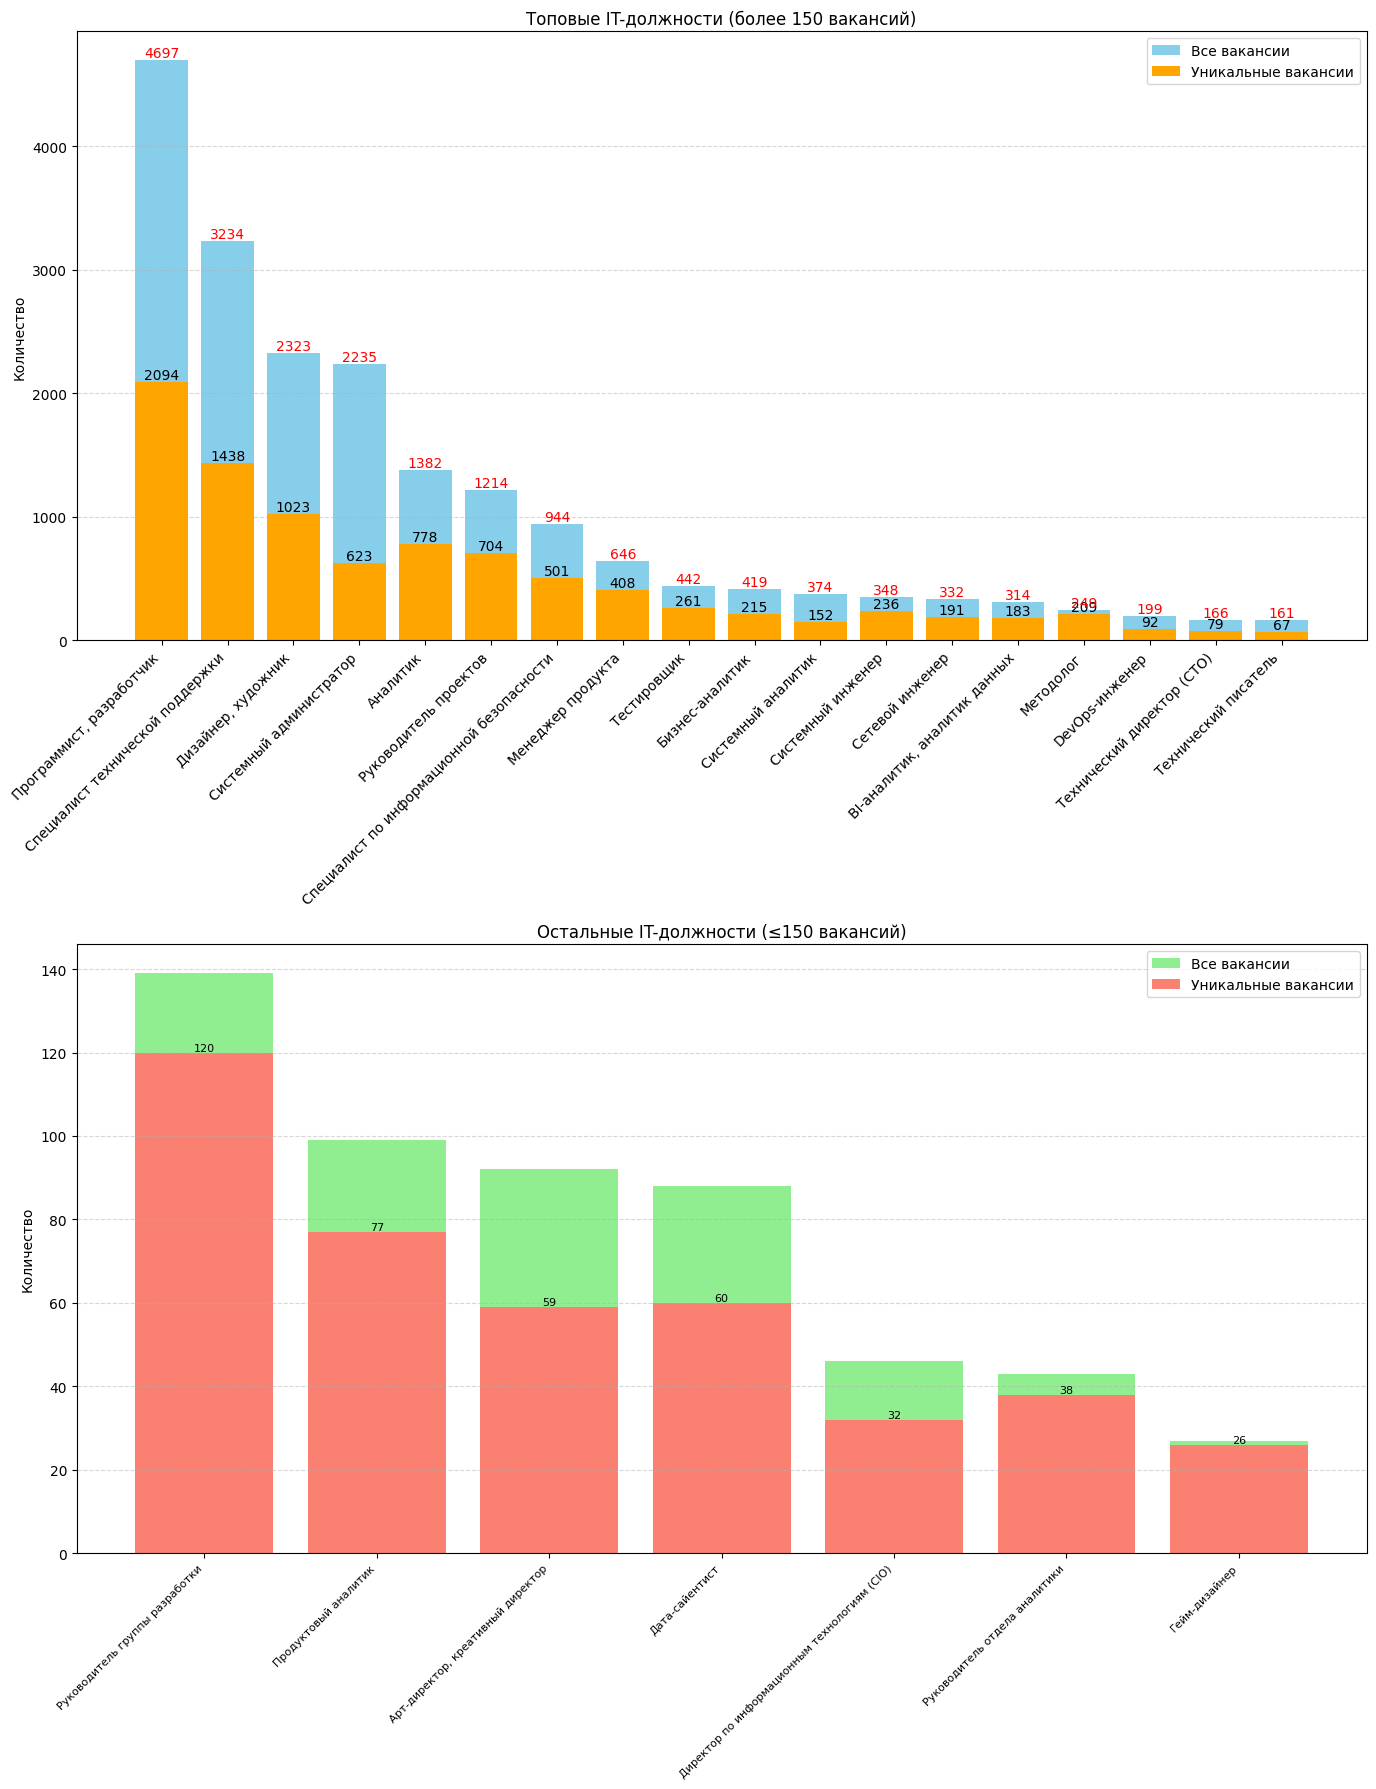

In [336]:

# Группировка данных
grouped = df.groupby('position')['vacancy it'].agg(['nunique', 'count']).sort_values('count', ascending=False)

# Разделение данных на две группы
top_positions = grouped[grouped['count'] > 150]
other_positions = grouped[grouped['count'] <= 150]

# Настройка стиля графиков
plt.figure(figsize=(14, 18))

# --- График 1: Топовые должности (>150 вакансий) ---
plt.subplot(2, 1, 1)
bars = plt.bar(top_positions.index, top_positions['count'], color='skyblue', label='Все вакансии')
plt.bar(top_positions.index, top_positions['nunique'], color='orange', label='Уникальные вакансии')

# Добавляем подписи значений
for bar, uniq, total in zip(bars, top_positions['nunique'], top_positions['count']):
    plt.text(bar.get_x() + bar.get_width()/2, uniq, f"{uniq}", ha='center', va='bottom', color='black')
    plt.text(bar.get_x() + bar.get_width()/2, total, f"{total}", ha='center', va='bottom', color='red')

plt.title('Топовые IT-должности (более 150 вакансий)')
plt.ylabel('Количество')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)

# --- График 2: Остальные должности (≤150 вакансий) ---
plt.subplot(2, 1, 2)
bars = plt.bar(other_positions.index, other_positions['count'], color='lightgreen', label='Все вакансии')
plt.bar(other_positions.index, other_positions['nunique'], color='salmon', label='Уникальные вакансии')

# Подписи значений (только для уникальных, если их мало)
for bar, uniq in zip(bars, other_positions['nunique']):
    if uniq > 0:  # Чтобы не загромождать график
        plt.text(bar.get_x() + bar.get_width()/2, uniq, f"{uniq}", ha='center', va='bottom', fontsize=8)

plt.title('Остальные IT-должности (≤150 вакансий)')
plt.ylabel('Количество')
plt.xticks(rotation=45, ha='right', fontsize=8)  # Уменьшаем шрифт, если много позиций
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

##### 2.3 Experience

In [337]:
df['experience'].value_counts(dropna= False).index.to_list()

['1–3 года',
 '3–6 лет',
 'Нет опыта',
 'Более 6 лет',
 'от 1 года',
 '3 года',
 'от 3 лет',
 'от 2 лет',
 '2–3 года',
 '1 год',
 'от 3-х лет',
 'от 6 месяцев',
 '2 года',
 '5 лет',
 'от 5 лет',
 '1-3 года',
 '3+ лет',
 'не менее 2 лет',
 '3+ года',
 'Опыт работы обязателен',
 'Опыт работы приветствуется',
 '3-6 лет',
 'без опыта',
 'Опыт работы не обязателен',
 'Опыт работы аналитиком или менеджером по продажам будет большим преимуществом',
 '5 years',
 'от 3 года',
 '1-2 года',
 '4 года',
 'Опыт работы флористом приветствуется',
 '6 мес',
 '1 до 6 лет',
 'Полиграфияда, жарнамада, багет шеберханасында және арнайы білім беруде (графикалық дизайнер, сәулетші, суретші-дизайнер, декоратор, мүсінші, бейнелеу өнері, басқа да шығармашылық мамандықтар) тәжірибенің болуы және графикалық бағдарламаларды білу (Corel Draw) құпталады.',
 'Желательно опыт работы в полиграфической сфере деятельности',
 '3+ года в UX/UI-дизайне',
 'Опыт работы в графическом дизайне',
 'Опыт работы в сфере телекоммуни

In [338]:
def normalize_experience(val):
    val = str(val).lower()

    # Категория: Нет опыта
    if any(x in val for x in [
        'без опыта', 'не требуется', 'нет опыта', 'не важен',
        'не обязателен', 'опыт не', 'отсутствие опыта'
    ]):
        return 'Нет опыта'

    # Категория: 1–3 года
    if any(x in val for x in [
        '1', '2', 'до 3', '1-3', '1–3', '1 до 3', 'от 6 мес', '6 мес', '6 месяцев', 'от года',
        '1.5 года', '1-2', '2-3', '1–2', '2–3', 'от 1 до 3', 'до 2', 'не менее года', 'обязателен', 'не менее двух лет', 'не менее 2 лет', 'двух лет'
    ]):
        return '1–3 года'

    # Категория: 3–6 лет
    if any(x in val for x in [
        '3', '4', '5', '3-6', '3–6', '4–5', '5–6', 'от 3', '3+',
        'от 4', 'от 5', '5 лет', '4 года', '3 года'
    ]):
        return '3–6 лет'

    # Категория: Более 6 лет
    if any(x in val for x in [
        '6 лет', '7 лет', 'более 6', '10 лет', 'от 6', '6+', '8 лет', '9 лет', 'более'
    ]):
        return 'Более 6 лет'

    # Дополнительная эвристика: если есть "опыт", но без чисел — отнесём к "1–3 года"
    if 'опыт' in val and not re.search(r'\d', val):
        return '1–3 года'

    return None

In [339]:
df['experience_norm'] = df['experience'].apply(normalize_experience)


In [340]:
print(df['experience_norm'].value_counts(dropna=False))

experience_norm
1–3 года       10828
3–6 лет         5211
Нет опыта       3441
Более 6 лет      732
None               1
Name: count, dtype: int64


In [341]:
display(df[df['experience_norm'].isna()]['experience'])

317    Полиграфияда, жарнамада, багет шеберханасында ...
Name: experience, dtype: object

In [342]:
df = df.dropna( subset=['experience_norm'])

In [343]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20212 entries, 0 to 21811
Data columns (total 37 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   position           20212 non-null  object 
 1   date               20212 non-null  object 
 2   vacancy            20212 non-null  object 
 3   company            20212 non-null  object 
 4   city               20212 non-null  object 
 5   experience         20212 non-null  object 
 6   employment         20212 non-null  object 
 7   schedule           20212 non-null  object 
 8   salary from        19485 non-null  float64
 9   salary to          17856 non-null  float64
 10  currency           20165 non-null  object 
 11  skills             20212 non-null  object 
 12  url                20212 non-null  object 
 13  ID                 20212 non-null  float64
 14  country            20212 non-null  object 
 15  industry           19102 non-null  object 
 16  text               20212 no

##### 2.5. Level

In [344]:
def extract_level(vacancy):
    """Максимально оптимизированная версия"""
    if not isinstance(vacancy, str):
        return 'Unknown'
    
    levels = {
        'chief': [
            r'\bchief\b',
            r'\bcto\b|\bcio\b|\bctio\b',
            #r'\bглавный\b',
            r'\bhead\s+of\b'
        ],
        'lead': [
            r'\btech\s*lead\b',
            r'\bteam\s*lead\b',
            r'\bteam\s*head\b',
            r'\bqa\s*lead\b',
            r'\blead\s+[a-z]+\b',  # Новый паттерн для Lead в начале
            r'\blead\b',  # Отдельное слово Lead
            r'\b[a-z]+\s+lead\b',  # Любое слово перед lead
            r'\bтехлид\b',
            #r'\bруководитель\b',
            #r'\bлид\b'
        ],
        
        'senior': [
            r'\bsenior\b',
            #r'\bстарший\b',
            #r'\bведущий\b'
        ],
        'middle': [
            r'\bmiddle\b',
            r'\bmid\b',
            r'\bсредний\b'
        ],
        'junior': [
            r'\bjunior\b',
            r'\bмладший\b'
        ],
        'trainee': [
            r'\bintern\b',
            r'\btrainee\b',
            r'\bстаж[ёе]р\b'
        ]
    }
    
    vacancy_lower = vacancy.lower()
    for level, patterns in levels.items():
        if any(re.search(p, vacancy_lower) for p in patterns):
            return level.capitalize()
    
    return 'Unknown'



In [345]:
# Создаём новый столбец 'level'
df['level'] = df['vacancy_norm'].apply(lambda x: extract_level(x))

In [346]:

def plot_salary_from_distribution(df):
    """
    Визуализирует распределение зарплат 'salary from' по уровням
    """
    plt.figure(figsize=(12, 6))
    
    # Фильтруем данные (убираем выбросы и нулевые значения)
    filtered = df[(df['country'] == 'Россия') & 
                (df['salary from'] > 10000) & 
                 (df['salary from'] < df['salary from'].quantile(0.99)) &
                 (df['level'] != 'Unknown')]
    
    # Строим boxplot
    sns.violinplot(
        x='level', 
        y='salary from', 
        data=filtered,
        order=['Trainee', 'Junior', 'Middle', 'Lead', 'Senior', 'Chief'],
        palette='viridis'
    )
    
    plt.title('Распределение зарплат "от" по уровням позиций')
    plt.xlabel('Уровень позиции')
    plt.ylabel('Зарплата "от" ')
    plt.xticks(rotation=45)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.show()
    
    # Возвращаем статистику
    return filtered.groupby('level')['salary from'].describe()

def plot_salary_to_distribution(df):
    """
    Визуализирует распределение зарплат 'salary to ' по уровням
    """
    plt.figure(figsize=(12, 6))
    
    # Фильтруем данные
    filtered = df[(df['country'] == 'Россия') & 
                (df['salary to'] > 10000) & 
                 (df['salary to'] < df['salary to'].quantile(0.99)) &
                 (df['level'] != 'Unknown')]
    
    # Строим violin plot для лучшего отображения распределения
    sns.violinplot(
        x='level', 
        y='salary to', 
        data=filtered,
        order=['Trainee', 'Junior', 'Middle', 'Lead', 'Senior', 'Chief'],
        palette='magma',
        cut=0
    )
    
    plt.title('Распределение зарплат "до" по уровням позиций')
    plt.xlabel('Уровень позиции')
    plt.ylabel('Зарплата "до" ')
    plt.xticks(rotation=45)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.show()
    
    # Возвращаем статистику
    return filtered.groupby('level')['salary to'].describe()

C:\Users\Aero-PC\AppData\Local\Temp\ipykernel_8844\3452694507.py:14: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




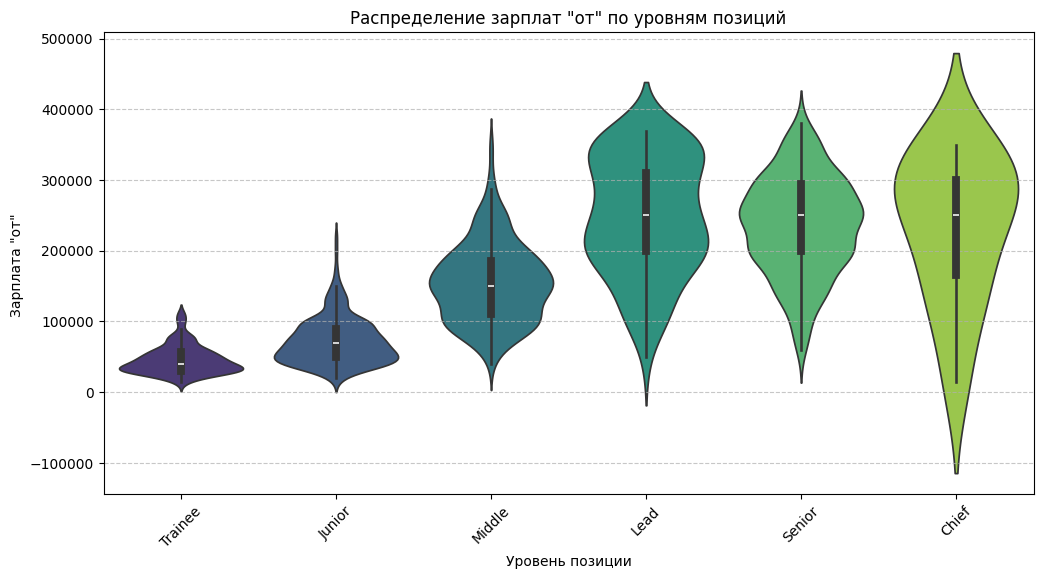

count           mean            std      min       25%       50%  \
level                                                                       
Chief     11.0  230454.545455  104605.318829  15000.0  165000.0  250000.0   
Junior   431.0   72758.218097   33324.643073  20000.0   50000.0   69000.0   
Lead      81.0  247282.530864   82587.563948  50000.0  200000.0  250000.0   
Middle   243.0  155166.255144   55494.305541  40000.0  110000.0  150000.0   
Senior   227.0  235200.885463   68814.025486  60000.0  200000.0  250000.0   
Trainee  201.0   46020.925373   19893.051095  15000.0   30000.0   40000.0   

              75%       max  
level                        
Chief    300000.0  350000.0  
Junior    90000.0  220000.0  
Lead     310000.0  370000.0  
Middle   185000.0  350000.0  
Senior   295000.0  380000.0  
Trainee   57000.0  110000.0

C:\Users\Aero-PC\AppData\Local\Temp\ipykernel_8844\3452694507.py:45: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




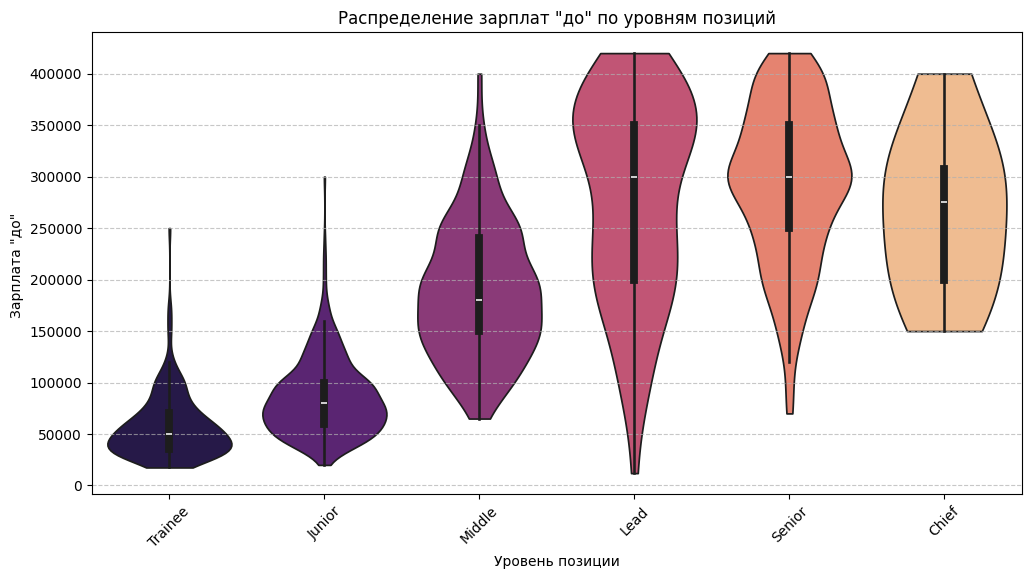

count           mean           std       min       25%       50%  \
level                                                                       
Chief      8.0  266250.000000  81755.296901  150000.0  200000.0  275000.0   
Junior   399.0   85790.218045  37271.168336   20000.0   60000.0   80000.0   
Lead      79.0  279896.556962  98599.216219   12000.0  200000.0  300000.0   
Middle   239.0  189104.184100  65004.919523   65000.0  150000.0  180000.0   
Senior   234.0  292476.500000  75997.067647   70000.0  250000.0  300000.0   
Trainee  189.0   57369.037037  31594.911805   17500.0   35000.0   50000.0   

              75%       max  
level                        
Chief    307500.0  400000.0  
Junior   100000.0  300000.0  
Lead     350000.0  420000.0  
Middle   240000.0  400000.0  
Senior   350000.0  420000.0  
Trainee   70000.0  250000.0

In [347]:
# Для зарплат "от"
stats_from = plot_salary_from_distribution(df)
display(stats_from)

# Для зарплат "до" 
stats_to = plot_salary_to_distribution(df)
display(stats_to)

##### 2.4 City, Country, employment, schedule

In [348]:
df['city'].value_counts(dropna=False)

city
Москва                                  6669
Санкт-Петербург                         2501
Екатеринбург                             626
Новосибирск                              518
Алматы                                   499
                                        ... 
Сосновый Бор (Ленинградская область)       1
Камень-на-Оби                              1
Северск (Томская область)                  1
Коммунарка (Московская область)            1
Гуково                                     1
Name: count, Length: 521, dtype: int64

In [349]:
df['country'].value_counts(dropna=False)

country
Россия            19078
Казахстан           979
Кыргызстан           97
Беларусь             19
Украина              18
Другие регионы       12
Узбекистан            4
Грузия                3
ОАЭ                   1
Сербия                1
Name: count, dtype: int64

In [350]:
df[df['country'] == 'Другие регионы']['city']

1057        ОАЭ
1058    Таиланд
1059        ОАЭ
1060      Китай
1061      Китай
1062    Таиланд
1063     Сербия
1064    Таиланд
1065        США
1066      Китай
1067        США
1068    Таиланд
Name: city, dtype: object

In [351]:
df['employment'].value_counts(dropna=False)

employment
Полная занятость       19576
Частичная занятость      494
Проектная работа         141
Стажировка                 1
Name: count, dtype: int64

In [352]:
df[df['employment'] == 'Стажировка']['salary from']

5148    50000.0
Name: salary from, dtype: float64

In [353]:
df = df[df['employment'] != 'Стажировка']

In [354]:
df['schedule'].value_counts(dropna=False)

schedule
Полный день         14463
Удаленная работа     4723
Сменный график        700
Гибкий график         267
Вахтовый метод         58
Name: count, dtype: int64

In [355]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20211 entries, 0 to 21811
Data columns (total 37 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   position           20211 non-null  object 
 1   date               20211 non-null  object 
 2   vacancy            20211 non-null  object 
 3   company            20211 non-null  object 
 4   city               20211 non-null  object 
 5   experience         20211 non-null  object 
 6   employment         20211 non-null  object 
 7   schedule           20211 non-null  object 
 8   salary from        19484 non-null  float64
 9   salary to          17855 non-null  float64
 10  currency           20164 non-null  object 
 11  skills             20211 non-null  object 
 12  url                20211 non-null  object 
 13  ID                 20211 non-null  float64
 14  country            20211 non-null  object 
 15  industry           19101 non-null  object 
 16  text               20211 no

#### 2.5. Region

In [356]:
df[df['country'] == 'Россия']['city'].value_counts()

city
Москва             6668
Санкт-Петербург    2500
Екатеринбург        625
Новосибирск         518
Казань              491
                   ... 
Арск                  1
Новый Оскол           1
Анна                  1
Шумерля               1
Гуково                1
Name: count, Length: 476, dtype: int64

In [357]:
df_copy=df

In [358]:

df_region = pd.DataFrame({'city': sorted(df[df['country'] == 'Россия']['city'].dropna().unique())})
df_region.loc[:, 'region'] = np.nan
df_region.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   city    476 non-null    object 
 1   region  0 non-null      float64
dtypes: float64(1), object(1)
memory usage: 7.6+ KB


In [359]:
#df_region.to_csv('data/df_region.csv', index=False)

In [360]:
df_mapped = pd.read_csv('data/df_region.csv')  # ← Файл с заполненными регионами

In [361]:
# Объединяем по колонке 'city'
df = df.merge(df_mapped, on='city', how='left')
df = df.dropna(subset = ['region']) # < - здесь отсеются и другие страны , если нужно сохранять то устанавливаем фильтр

In [362]:
df_mapped[df_mapped['region'].isna()]

city region
68      Вольгинский    NaN
93        Долиновка    NaN
175  Краснобродский    NaN
203         Луганск    NaN
206         Лычково    NaN
216      Месягутово    NaN
230      Набережный    NaN
347        Ставрово    NaN
351   Степное Озеро    NaN
407      Челбасская    NaN
419         Чусовой    NaN

In [363]:
with pd.option_context('display.max_rows', 100):
    display(df['region'].value_counts(dropna=False).tail(50))

region
Республика Марий Эл                         57
Курская область                             57
Ульяновская область                         56
Костромская область                         48
Тамбовская область                          47
Ханты-Мансийский автономный округ           47
Брянская область                            45
Смоленская область                          43
Ленинградская область                       39
Амурская область                            37
Псковская область                           34
Республика Саха (Якутия)                    31
Республика Мордовия                         30
Мурманская область                          29
Бурятия                                     29
Астраханская область                        27
Орловская область                           27
Курганская область                          27
Республика Карелия                          26
Архангельская область                       24
Новгородская область                        22
Респуб

In [364]:
# Уберем регионы с < 20 записей в регионе 
mask = df['region'].value_counts() >= 20
df = df[df['region'].isin(mask[mask].index)]

In [365]:
df['region'].value_counts()

region
Москва                   6732
Санкт-Петербург          2508
Свердловская область      678
Краснодарский край        632
Республика Татарстан      595
                         ... 
Курганская область         27
Республика Карелия         26
Архангельская область      24
Новгородская область       22
Республика Дагестан        20
Name: count, Length: 65, dtype: int64

In [366]:
df['country'].value_counts()

country
Россия     18861
Украина        8
Name: count, dtype: int64

In [367]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18869 entries, 1110 to 20210
Data columns (total 38 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   position           18869 non-null  object 
 1   date               18869 non-null  object 
 2   vacancy            18869 non-null  object 
 3   company            18869 non-null  object 
 4   city               18869 non-null  object 
 5   experience         18869 non-null  object 
 6   employment         18869 non-null  object 
 7   schedule           18869 non-null  object 
 8   salary from        18153 non-null  float64
 9   salary to          16553 non-null  float64
 10  currency           18822 non-null  object 
 11  skills             18869 non-null  object 
 12  url                18869 non-null  object 
 13  ID                 18869 non-null  float64
 14  country            18869 non-null  object 
 15  industry           18869 non-null  object 
 16  text               18869

#### 3. EDA

##### 3.1. Salary

In [368]:
# отсекаем почасовую и сдельную работу

#df = df_copy 

df = df[(df['salary from'] >= 10000) & (df['salary to'] >= 10000)]

is_normal_salary from  \
position                                                             
BI-аналитик, аналитик данных                                 False   
DevOps-инженер                                               False   
Аналитик                                                     False   
Арт-директор, креативный директор                            False   
Бизнес-аналитик                                              False   
Гейм-дизайнер                                            too_small   
Дата-сайентист                                                True   
Дизайнер, художник                                           False   
Директор по информационным технологиям (CIO)                 False   
Менеджер продукта                                            False   
Методолог                                                    False   
Программист, разработчик                                     False   
Продуктовый аналитик                                         False   
Руководитель группы разработки                               False   
Руководитель отдела аналитики                                False   
Руководитель проектов                                        False   
Сетевой инженер                                              False   
Системный администратор                                      False   
Системный аналитик                                           False   
Системный инженер                                            False   
Специалист по информационной безопасности                    False   
Специалист технической поддержки                             False   
Тестировщик                                                  False   
Технический директор (CTO)                                   False   
Технический писатель                                         False   

                                             is_normal_salary to  \
position                                                           
BI-аналитик, аналитик данных                               False   
DevOps-инженер                                             False   
Аналитик                                                   False   
Арт-директор, креативный директор                          False   
Бизнес-аналитик                                            False   
Гейм-дизайнер                                          too_small   
Дата-сайентист                                              True   
Дизайнер, художник                                         False   
Директор по информационным технологиям (CIO)               False   
Менеджер продукта                                          False   
Методолог                                                  False   
Программист, разработчик                                   False   
Продуктовый аналитик                                       False   
Руководитель группы разработки                             False   
Руководитель отдела аналитики                              False   
Руководитель проектов                                      False   
Сетевой инженер                                            False   
Системный администратор                                    False   
Системный аналитик                                         False   
Системный инженер                                          False   
Специалист по информационной безопасности                  False   
Специалист технической поддержки                           False   
Тестировщик                                                False   
Технический директор (CTO)                                 False   
Технический писатель                                       False   

                                             n_removed_salary from  \
position                                                             
BI-аналитик, аналитик данных                                    10   
DevOps-инженер                                                   3   
Аналитик                             

C:\Users\Aero-PC\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.



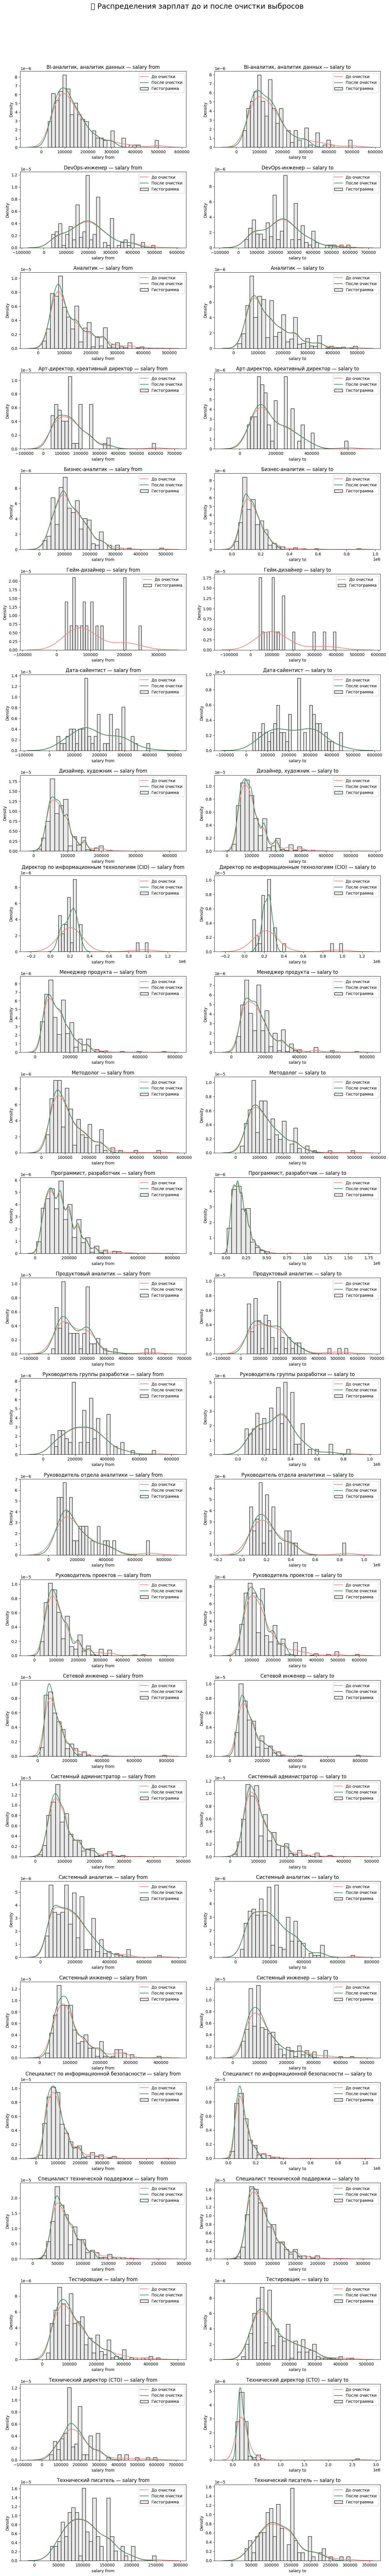

In [369]:

from scipy.stats import normaltest

# Создаём копию безопасно
df_copy = df.copy()

# Создаём колонки для нормализованных значений
df.loc[:, 'salary from norm'] = np.nan
df.loc[:, 'salary to norm'] = np.nan

# Для сбора отчёта
report = []

# Функция очистки и нормализации
def process_series(series, colname, position):
    series = pd.to_numeric(series, errors='coerce')
    series = series.dropna()
    n_total = len(series)

    if n_total <= 20:
        report.append({
            'position': position,
            'column': colname,
            'is_normal': 'too_small',
            'n_total': n_total,
            'n_filtered': n_total,
            'n_removed': 0,
            'p_value': np.nan
        })
        return None  # потом заменим

    stat, p = normaltest(series)
    is_normal = p > 0.05

    if is_normal:
        mu, sigma = series.mean(), series.std()
        mask = (series >= mu - 3 * sigma) & (series <= mu + 3 * sigma)
    else:
        q1 = series.quantile(0.25)
        q3 = series.quantile(0.75)
        iqr = q3 - q1
        mask = (series >= q1 - 1.5 * iqr) & (series <= q3 + 1.5 * iqr)

    n_filtered = mask.sum()
    n_removed = n_total - n_filtered

    report.append({
        'position': position,
        'column': colname,
        'is_normal': is_normal,
        'n_total': n_total,
        'n_filtered': n_filtered,
        'n_removed': n_removed,
        'p_value': p
    })

    return series[mask]

# Обработка по каждой позиции
positions = df['position'].dropna().unique()

for pos in positions:
    mask_pos = df['position'] == pos
    for col in ['salary from', 'salary to']:
        clean_series = process_series(df.loc[mask_pos, col], col, pos)
        if clean_series is not None:
            index_valid = clean_series.index
            df.loc[index_valid, f'{col} norm'] = clean_series

# Собираем и форматируем отчёт
report_df = pd.DataFrame(report)

# Сводная таблица
report_summary = report_df.pivot(index='position', columns='column', values=['is_normal', 'n_removed', 'n_total', 'p_value'])
report_summary.columns = ['_'.join(col).strip() for col in report_summary.columns.values]

# Показываем таблицу
display(report_summary)

# Визуализация распределений
n_positions = len(positions)
fig, axs = plt.subplots(n_positions, 2, figsize=(14, n_positions * 3.5))
fig.tight_layout(pad=4)

for idx, pos in enumerate(positions):
    for j, col in enumerate(['salary from', 'salary to']):
        ax = axs[idx][j] if n_positions > 1 else axs[j]
        before = df[df_copy['position'] == pos][col]
        after = df[df_copy['position'] == pos][f'{col} norm']

        sns.histplot(before, ax=ax, bins=30, stat='density', color='lightgray', alpha=0.5, label='Гистограмма')
        sns.kdeplot(before, ax=ax, color='salmon', label='До очистки')
        sns.kdeplot(after.dropna(), ax=ax, color='seagreen', label='После очистки')

        ax.set_title(f"{pos} — {col}")
        ax.legend()

plt.suptitle("📊 Распределения зарплат до и после очистки выбросов", fontsize=18, y=1.02)
plt.show()


In [370]:
for pos in positions:
    pos_mask = df['position'] == pos

    for col in ['salary from', 'salary to']:
        # очищаем колонку от выбросов
        cleaned_series = process_series(
            df_copy.loc[pos_mask, col],
            col,
            pos
        )

        # сохраняем очищенные значения в новую колонку
        df.loc[pos_mask, f'{col} norm'] = cleaned_series

In [371]:
df_copy = df.copy()

In [372]:
#df = df_copy

In [373]:
df = df.dropna(subset=['salary from norm', 'salary to norm'], how='any')

In [374]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14980 entries, 1110 to 20203
Data columns (total 40 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   position           14980 non-null  object 
 1   date               14980 non-null  object 
 2   vacancy            14980 non-null  object 
 3   company            14980 non-null  object 
 4   city               14980 non-null  object 
 5   experience         14980 non-null  object 
 6   employment         14980 non-null  object 
 7   schedule           14980 non-null  object 
 8   salary from        14980 non-null  float64
 9   salary to          14980 non-null  float64
 10  currency           14973 non-null  object 
 11  skills             14980 non-null  object 
 12  url                14980 non-null  object 
 13  ID                 14980 non-null  float64
 14  country            14980 non-null  object 
 15  industry           14980 non-null  object 
 16  text               14980

##### 3.2 Level

In [375]:
df['level'].value_counts()

level
Unknown    13942
Junior       381
Middle       209
Senior       194
Trainee      173
Lead          74
Chief          7
Name: count, dtype: int64

In [376]:
def plot_salary_from_distribution(df):
    """
    Визуализирует распределение зарплат 'salary from norm' по уровням
    """
    plt.figure(figsize=(12, 6))
    
    # Фильтруем данные (убираем выбросы и нулевые значения)
    filtered = df[(df['country'] == 'Россия') &
                 (df['level'] != 'Unknown')]
    
    # Строим boxplot
    sns.violinplot(
        x='level', 
        y='salary from norm', 
        data=filtered,
        order=['Trainee', 'Junior', 'Middle', 'Lead', 'Senior', 'Chief'],
        palette='viridis'
    )
    
    plt.title('Распределение зарплат "от" по уровням позиций')
    plt.xlabel('Уровень позиции')
    plt.ylabel('Зарплата "от" ')
    plt.xticks(rotation=45)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.show()
    
    # Возвращаем статистику
    return filtered.groupby('level')['salary from norm'].describe()

def plot_salary_to_distribution(df):
    """
    Визуализирует распределение зарплат 'salary to norm ' по уровням
    """
    plt.figure(figsize=(12, 6))
    
    # Фильтруем данные
    filtered = df[(df['country'] == 'Россия') &
                 (df['level'] != 'Unknown')]
    
    # Строим violin plot для лучшего отображения распределения
    sns.violinplot(
        x='level', 
        y='salary to norm', 
        data=filtered,
        order=['Trainee', 'Junior', 'Middle', 'Lead', 'Senior', 'Chief'],
        palette='magma',
        cut=0
    )
    
    plt.title('Распределение зарплат "до" по уровням позиций')
    plt.xlabel('Уровень позиции')
    plt.ylabel('Зарплата "до" ')
    plt.xticks(rotation=45)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.show()
    
    # Возвращаем статистику
    return filtered.groupby('level')['salary to norm'].describe()

C:\Users\Aero-PC\AppData\Local\Temp\ipykernel_8844\1975187416.py:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




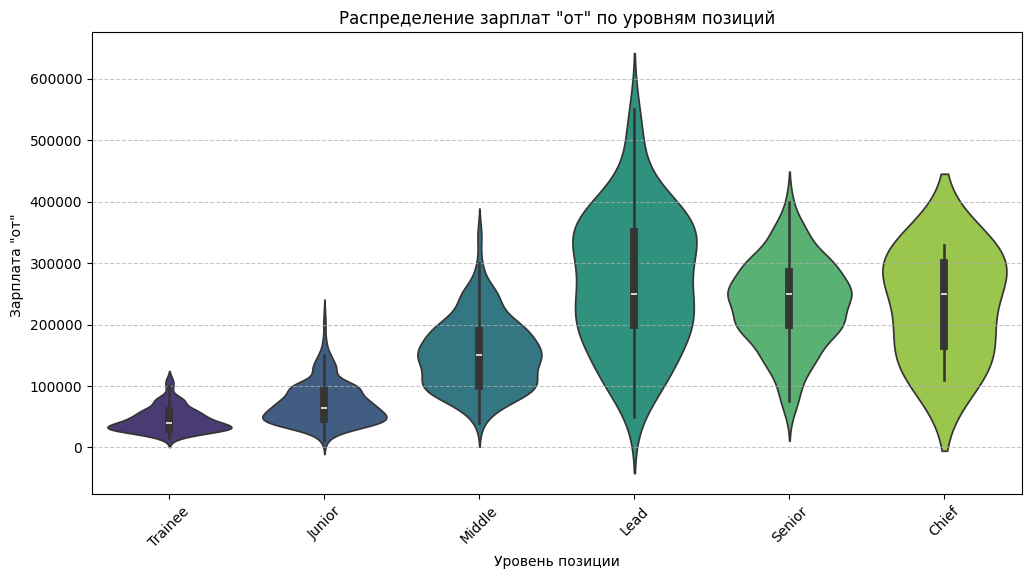

count           mean            std       min       25%       50%  \
level                                                                        
Chief      7.0  231428.571429   85132.949248  110000.0  165000.0  250000.0   
Junior   381.0   72176.895013   33857.485329   10000.0   47000.0   65000.0   
Lead      74.0  271890.337838  108422.359274   50000.0  200000.0  250000.0   
Middle   209.0  153037.799043   56503.246647   40000.0  100000.0  150000.0   
Senior   194.0  233920.623711   70160.873013   60000.0  200000.0  250000.0   
Trainee  173.0   45665.930636   19941.407951   15000.0   30000.0   40000.0   

              75%       max  
level                        
Chief    300000.0  330000.0  
Junior    92000.0  220000.0  
Lead     350000.0  550000.0  
Middle   190000.0  350000.0  
Senior   285325.0  400000.0  
Trainee   60000.0  110000.0

C:\Users\Aero-PC\AppData\Local\Temp\ipykernel_8844\1975187416.py:41: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




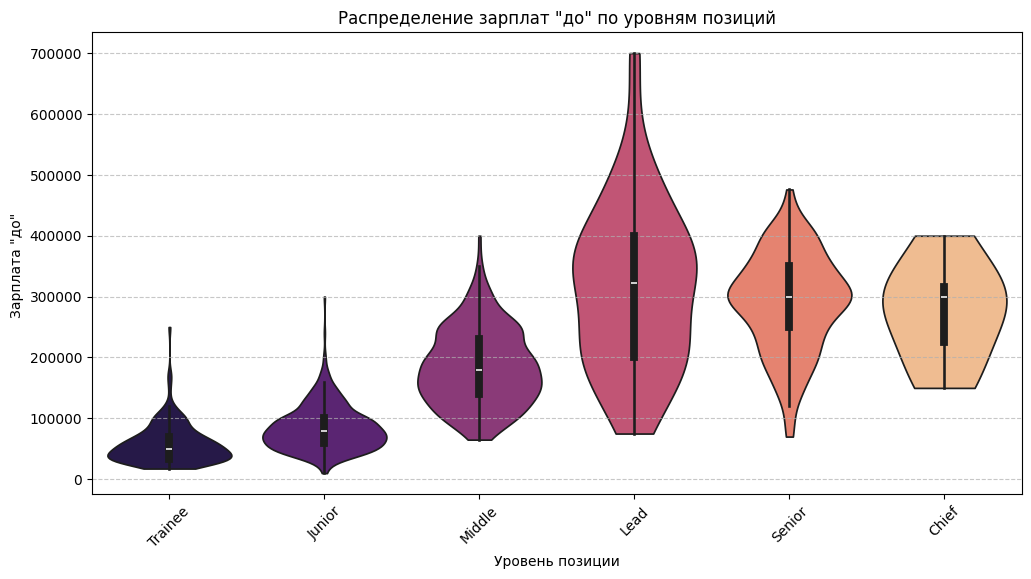

count           mean            std       min       25%       50%  \
level                                                                        
Chief      7.0  275714.285714   83438.029470  150000.0  225000.0  300000.0   
Junior   381.0   84296.317585   36663.945063   10000.0   60000.0   80000.0   
Lead      74.0  315335.513514  136695.661336   75000.0  200000.0  322500.0   
Middle   209.0  183760.287081   62789.973492   65000.0  140000.0  180000.0   
Senior   194.0  289765.469072   80046.735477   70000.0  250000.0  300000.0   
Trainee  173.0   57714.346821   31885.167015   17500.0   34000.0   50000.0   

              75%       max  
level                        
Chief    315000.0  400000.0  
Junior   100000.0  300000.0  
Lead     400000.0  700000.0  
Middle   230000.0  400000.0  
Senior   350000.0  476000.0  
Trainee   70000.0  250000.0

In [377]:
# Для зарплат "от"
stats_from = plot_salary_from_distribution(df)
display(stats_from)

# Для зарплат "до" 
stats_to = plot_salary_to_distribution(df)
display(stats_to)

In [378]:
# Для начала заполним level из experience level там где не определено нашей регуляркой

In [379]:
display(df[(df['level'] == 'Unknown') & (~df['experience level'].isna())]['experience level'])

1110              Middle
1111              Middle
1112            от 2 лет
1113             Средний
1114            от 2 лет
              ...       
20175            средний
20180    средний/старший
20181            Средний
20200            Средний
20203            Средний
Name: experience level, Length: 2370, dtype: object

In [380]:
no_level = set(df[(df['level'] == 'Unknown') & (~df['experience level'].isna())]['experience level'].to_list())

In [381]:
display(no_level)

{'1 год',
 '1 год и более',
 '1-3 года',
 '2+ года',
 '2-ой линии поддержки',
 '3 года',
 '3 года и более',
 '3+ года',
 '3+ лет',
 '4+ лет',
 '5 лет',
 '5+ лет',
 '6 лет',
 'June+',
 'Junior',
 'Junior+/Middle',
 'Junior/Junior+',
 'Junior/Middle',
 'MIDDLE',
 'Middle',
 'Middle и выше',
 'Middle или Middle+',
 'Middle+/Senior',
 'Middle/+',
 'Middle/Middle+',
 'Middle/Senior',
 'Senior',
 'Senior/Lead',
 "['Middle', 'Middle+', 'Senior']",
 "['без опыта', 'с опытом']",
 "['руководитель группы разработчиков (team lead)', 'архитектор', 'аналитик системы/бизнес-аналитик', 'ведущий разработчик (senior developer)', 'инженер БД (Data Engineer)', 'разработчик (middle developer)', 'младший разработчик (junior developer)', 'техподдержка 2 уровень (support 2 level)', 'техподдержка 1 уровень (support 1 level)']",
 '[]',
 'junior',
 'junior/middle',
 'mid2-sen1,2',
 'midcore-проекты',
 'middle',
 'middle+',
 'middle/senior',
 'senior',
 'senior, middle, middle+',
 'senior/upper_middle',
 'Базовый

In [382]:
#df = df_copy

In [383]:
# этот блок не нужен в случае прогона с начала
'''

# Маска для условий:
# 1. В vacancy есть "руководитель" ИЛИ "лид" (как отдельные слова, без учета регистра)
# 2. Текущий level равен "Lead"
mask = (
    df['vacancy'].str.contains(r'\b(руководитель|лид)\b', case=False, regex=True, na=False) & 
    (df['level'] == 'Lead')
)

# Заменяем "Lead" на "no" для найденных строк
df.loc[mask, 'level'] = 'no'

# Проверка результата
changed_rows = df[mask]
print(f"Изменено строк: {len(changed_rows)}")
if len(changed_rows) > 0:
    display(changed_rows[['vacancy', 'level']].sample(min(5, len(changed_rows)), random_state=1))



# Создаем маску для условий:
# 1. В vacancy есть слова "старший" или "ведущий" (как отдельные слова)
# 2. Текущее значение level равно "Senior"
mask = (
    df['vacancy'].str.contains(r'\b(старший|ведущий)\b', case=False, regex=True, na=False) & 
    (df['level'] == 'Senior')
)

# Применяем замену
df.loc[mask, 'level'] = 'no'

# Проверка результата
changed_rows = df[mask]
print(f"Изменено строк: {len(changed_rows)}")
if len(changed_rows) > 0:
    display(changed_rows[['vacancy', 'level']].head())
    
    '''

'\n\n# Маска для условий:\n# 1. В vacancy есть "руководитель" ИЛИ "лид" (как отдельные слова, без учета регистра)\n# 2. Текущий level равен "Lead"\nmask = (\n    df[\'vacancy\'].str.contains(r\'\x08(руководитель|лид)\x08\', case=False, regex=True, na=False) & \n    (df[\'level\'] == \'Lead\')\n)\n\n# Заменяем "Lead" на "no" для найденных строк\ndf.loc[mask, \'level\'] = \'no\'\n\n# Проверка результата\nchanged_rows = df[mask]\nprint(f"Изменено строк: {len(changed_rows)}")\nif len(changed_rows) > 0:\n    display(changed_rows[[\'vacancy\', \'level\']].sample(min(5, len(changed_rows)), random_state=1))\n\n\n\n# Создаем маску для условий:\n# 1. В vacancy есть слова "старший" или "ведущий" (как отдельные слова)\n# 2. Текущее значение level равно "Senior"\nmask = (\n    df[\'vacancy\'].str.contains(r\'\x08(старший|ведущий)\x08\', case=False, regex=True, na=False) & \n    (df[\'level\'] == \'Senior\')\n)\n\n# Применяем замену\ndf.loc[mask, \'level\'] = \'no\'\n\n# Проверка результата\nchanged

In [384]:
def extract_level_from_experience(experience):
    """Функция для определения уровня из опыта работы"""
    if not isinstance(experience, str):
        return 'Unknown'
    
    experience_lower = experience.lower().strip()
    
    # Сначала проверяем явные указания уровней
    level_mapping = {
        'chief': ['head of'],
        'lead': [
                'lead', 'главный',
                'team lead', 'senior/lead', 'ведущий разработчик',
                'руководитель группы', 'техлид' # 'лид', 'руководитель', 'эксперт'
            ],
            'senior': [
                'senior', 'сеньор', 'высший', 'высокая квалификация', #'старший'
                'свыше 5 лет', '5+ лет', '10 лет', '5 лет', '6 лет', 'от 5 лет', '4+ лет',
                'senior/upper_middle', 'senior, middle, middle+',
                 'middle+', 'middle/senior', 'middle+/senior' # 'средний/ведущий специалист', 'опытный специалист', 'опытный', 'старший уровень', 
            ],
            'middle': [
                'middle', 'мидл', 'mid',  '3 года', '3–6 лет', 
                '1-3 года', '2+ года', '3+ года',  'от 2 лет', 'от 2-х лет',
                'junior+/middle',
                'junior/middle', 'mid2-sen1,2', 'средний (middle)', 'средний уровень',
                'средний/высокий', 'средний/старший', 'ведущий',
                'ведущий специалист' # 'опыт работы', 'с опытом', 'средний',
            ],
            'junior': [
                'junior', 'джуниор', 'младший', 'начинающий', 'начальный', 'новичок',
                '1 год', '1+ год опыта', 'любой', 'джун',
                'junior/junior+', 'junior/middle', 'начинающий специалист', 
                'для начинающих', 'начальный уровень', 'нет опыта', 'без опыта', 'без опыта',
                'можно без опыта',
                'стартовый уровень', 'без опыта работы',
                'начинающий или опытный', 'для начинающих',
                'без требований к опыту', 'стажер/младший специалист'
                'нет требований', 'новичок', 'любой уровень опыта', 'с минимальным опытом', 'не требуется', 'от 6 месяцев', 'от 1 года'
            ],
            'trainee': [
                'trainee', 'стажер', 'стажёр', 'студент'
            ]

    }
    
    for level, keywords in level_mapping.items():
        if any(keyword in experience_lower for keyword in keywords):
            return level.capitalize()

    
    return 'Unknown'

# 'не указан', 'не указано',

In [385]:
df[df['level'] == 'Unknown'].shape

(13942, 40)

In [386]:
mask = (df['level'] == 'Unknown') & (~df['experience level'].isna())

In [387]:
# Применяем функцию к столбцу experience_level
#df[mask]['level'] = df['experience level'].apply(lambda x: extract_level_from_experience(x))
df['level_copy'] = df['level']
df.loc[mask, 'level'] = df.loc[mask, 'experience level'].apply(lambda x: extract_level_from_experience(x))

In [388]:
def plot_salary_from_distribution(df):
    """
    Визуализирует распределение зарплат 'salary from norm' по всем уровням, включая 'Unknown'
    """
    plt.figure(figsize=(14, 7))
    
    # Фильтруем данные
    filtered = df[(df['country'] == 'Россия')]
    
    # Определяем порядок уровней (добавляем 'no' в конец)
    level_order = ['Trainee', 'Junior', 'Middle', 'Lead', 'Senior', 'Chief', 'Unknown']
    
    # Строим violinplot
    sns.violinplot(
        x='level', 
        y='salary from norm', 
        data=filtered,
        order=level_order,
        palette=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#7f7f7f'],
        cut=0
    )
    
    plt.title('Распределение зарплат "от" по всем уровням позиций (включая "no")')
    plt.xlabel('Уровень позиции')
    plt.ylabel('Зарплата "от"')
    plt.xticks(rotation=45)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.show()
    
    # Возвращаем статистику для всех уровней
    return filtered.groupby('level')['salary from norm'].describe().reindex(level_order)

def plot_salary_to_distribution(df):
    """
    Визуализирует распределение зарплат 'salary to norm' по всем уровням, включая 'no'
    """
    plt.figure(figsize=(14, 7))
    
    # Фильтруем данные
    filtered = df[(df['country'] == 'Россия')]
    
    # Определяем порядок уровней (добавляем 'no' в конец)
    level_order = ['Trainee', 'Junior', 'Middle', 'Lead', 'Senior', 'Chief', 'Unknown']
    
    # Строим violinplot
    sns.violinplot(
        x='level', 
        y='salary to norm', 
        data=filtered,
        order=level_order,
        palette=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#7f7f7f'],
        cut=0
    )
    
    plt.title('Распределение зарплат "до" по всем уровням позиций (включая "Unknown")')
    plt.xlabel('Уровень позиции')
    plt.ylabel('Зарплата "до"')
    plt.xticks(rotation=45)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.show()
    
    # Возвращаем статистику для всех уровней
    return filtered.groupby('level')['salary to norm'].describe().reindex(level_order)

C:\Users\Aero-PC\AppData\Local\Temp\ipykernel_8844\4012837835.py:14: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




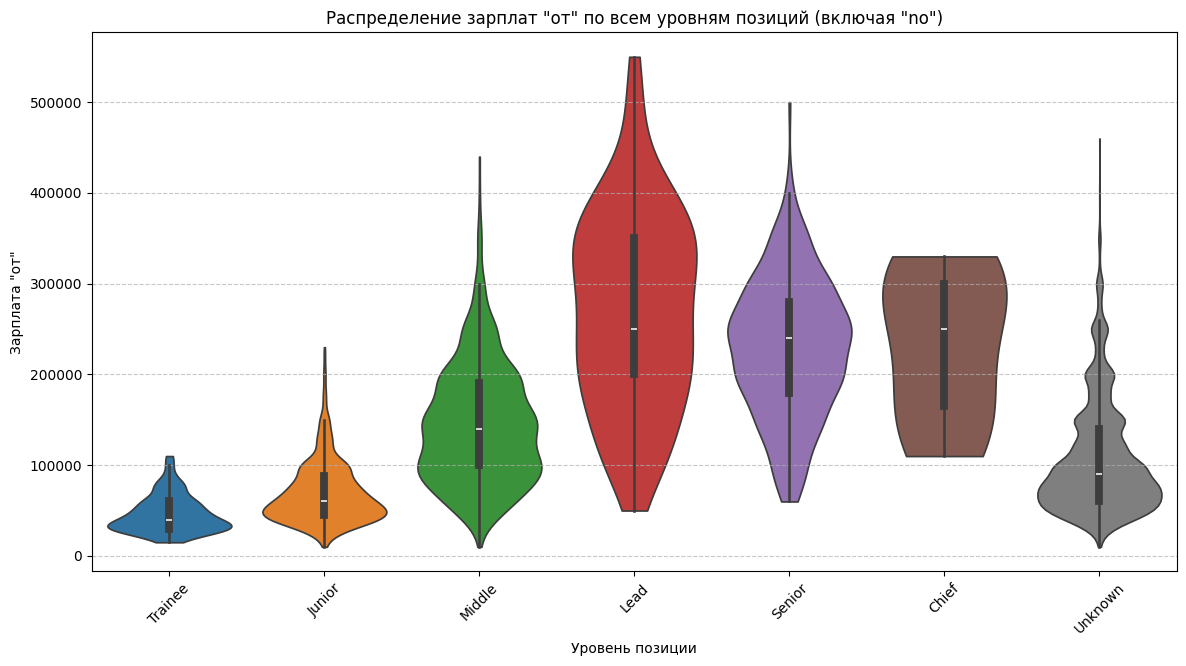

count           mean            std       min       25%       50%  \
level                                                                          
Trainee    178.0   46349.471910   20422.797323   15000.0   30000.0   40000.0   
Junior     736.0   69348.501359   33668.541045   10000.0   45000.0   60000.0   
Middle     649.0  144717.020031   65254.531978   10000.0  100000.0  140000.0   
Lead        76.0  270130.065789  108622.154126   50000.0  200000.0  250000.0   
Senior     258.0  229420.934109   75572.762426   60000.0  180000.0  240000.0   
Chief        7.0  231428.571429   85132.949248  110000.0  165000.0  250000.0   
Unknown  13071.0  107736.049193   61860.332961   10000.0   60000.0   90000.0   

              75%       max  
level                        
Trainee   60000.0  110000.0  
Junior    88000.0  230000.0  
Middle   190000.0  440000.0  
Lead     350000.0  550000.0  
Senior   280000.0  500000.0  
Chief    300000.0  330000.0  
Unknown  140000.0  460000.0

C:\Users\Aero-PC\AppData\Local\Temp\ipykernel_8844\4012837835.py:46: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




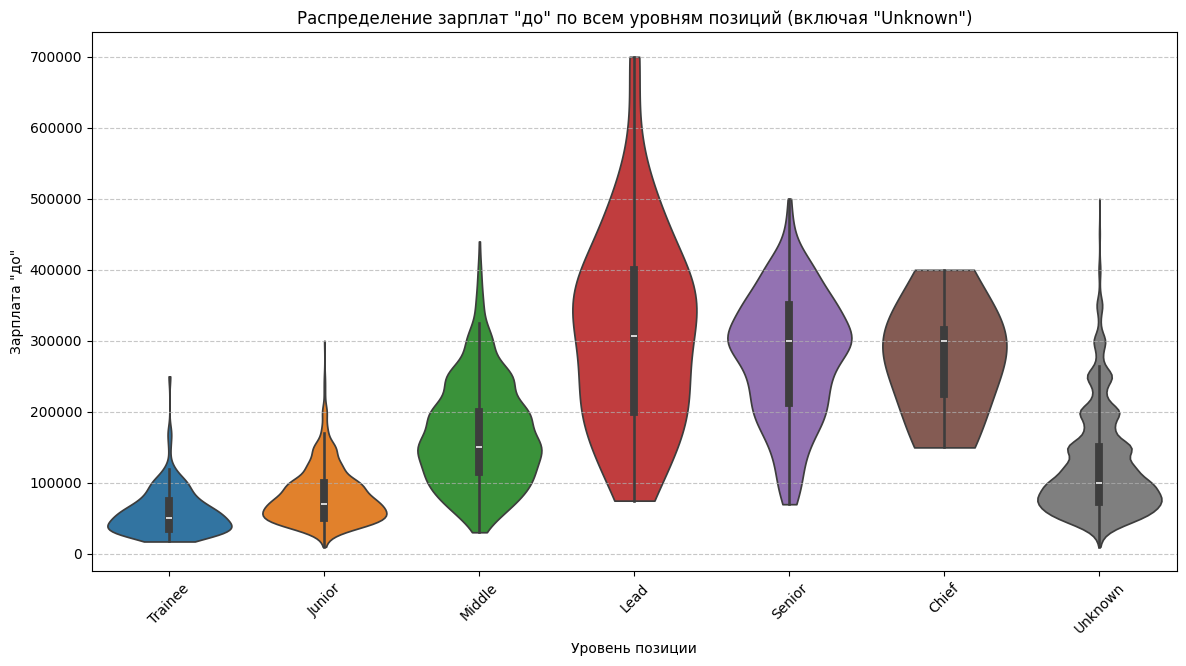

count           mean            std       min       25%       50%  \
level                                                                          
Trainee    178.0   58199.898876   31655.649901   17500.0   35000.0   50000.0   
Junior     736.0   81421.650815   37839.888194   10000.0   50650.0   70000.0   
Middle     649.0  168196.742681   72121.130447   30500.0  115000.0  150000.0   
Lead        76.0  312431.947368  136909.385976   75000.0  200000.0  307500.0   
Senior     258.0  277687.988372   86096.050592   70000.0  212500.0  300000.0   
Chief        7.0  275714.285714   83438.029470  150000.0  225000.0  300000.0   
Unknown  13071.0  124733.129447   70749.743301   10000.0   73000.0  100000.0   

              75%       max  
level                        
Trainee   75000.0  250000.0  
Junior   100000.0  300000.0  
Middle   200000.0  440000.0  
Lead     400000.0  700000.0  
Senior   350000.0  500000.0  
Chief    315000.0  400000.0  
Unknown  150000.0  500000.0

In [389]:
# Для зарплат "от"
stats_from = plot_salary_from_distribution(df)
display(stats_from)

# Для зарплат "до" 
stats_to = plot_salary_to_distribution(df)
display(stats_to)

In [390]:
# нужно посмотреть на аномальные для категории строчки и понять в чем проблема 

# начнем с salary from norm

# junior
mask = (df['level'] == 'Junior') & (df['salary from norm'] > 150000)
df[mask]

position                      date  \
1430                              DevOps-инженер  2025-05-23T17:40:48+0300   
2112                                    Аналитик  2025-06-06T16:02:00+0300   
2146                                    Аналитик  2025-06-02T10:05:40+0300   
4552                           Менеджер продукта  2025-06-06T08:55:05+0300   
5949                    Программист, разработчик  2025-06-05T18:13:37+0300   
6587                    Программист, разработчик  2025-06-06T09:30:24+0300   
7096                    Программист, разработчик  2025-05-21T01:46:12+0300   
9043                             Сетевой инженер  2025-06-05T10:07:35+0300   
9810                     Системный администратор  2025-06-06T11:42:31+0300   
10957                         Системный аналитик  2025-06-02T15:38:28+0300   
11008                         Системный аналитик  2025-05-12T15:37:13+0300   
11539  Специалист по информационной безопасности  2025-05-16T17:53:22+0300   
14501                                Тестировщик  2025-05-27T16:36:50+0300   
16279                          Менеджер продукта  2025-06-30T10:52:46+0300   
17978                      Руководитель проектов  2025-06-11T11:42:22+0300   

                                                 vacancy  \
1430   Support Integration Manager / Junior Solution ...   
2112                     Аналитик прогнозирования спроса   
2146                                         Аналитик 1С   
4552                   Ассистент категорийного менеджера   
5949                                     Программист C++   
6587                                      Программист 1C   
7096                                      Программист 1С   
9043                                     Сетевой инженер   
9810                                              Devops   
10957                         Full-stack аналитик junior   
11008                     Младший системный аналитик РЭА   
11539     Младший эксперт по информационной безопасности   
14501           Инженер нагрузочного тестирования Junior   
16279                   Project Manager / Junior Product   
17978                          Junior IT project manager   

                                                 company             city  \
1430                                  Lenkep recruitment           Москва   
2112                                        Русское море           Москва   
2146                Университет науки и технологий МИСИС           Москва   
4552    КОМПАНИЯ РМС (Ростовская Мануфактура Сантехники)   Ростов-на-Дону   
5949                                                ЭТМС       Зеленоград   
6587                                              Хакель  Санкт-Петербург   
7096                   Группа компаний Юнион Владивосток      Владивосток   
9043                                            Совфрахт           Москва   
9810                                       Сократ Мниирс           Москва   
10957                                               ABCP           Москва   
11008  Научно-производственное объединение дальней ра...           Москва   
11539                              Онлайн-школа Фоксфорд           Москва   
14501                                         Альфа-Банк           Москва   
16279                                          Техноавиа           Москва   
17978                                               ECCO           Москва   

      experience        employment          schedule  salary from  salary to  \
1430    1–3 года  Полная занятость  Удаленная работа     200000.0   200000.0   
2112   Нет опыта  Полная занятость       Полный день     180000.0   180000.0   
2146    1–3 года  Полная занятость       Полный день     168000.0   168000.0   
4552    1–3 года  Полная занятость       Полный день     180000.0   180000.0   
5949    1–3 года  Полная занятость       Полный день     220000.0   220000.0   
6587     3–6 лет  Полная занятость       Полный день     230000.0   230000.0   
7096    1–3 года  Полная занятость   

In [391]:
# гипотиза для правки 
df.loc[(df['experience_norm'] == '3–6 лет') & (df['level'] == 'Junior'), 'level'] = 'Middle'

In [392]:
#df[mask].to_excel('temp.xlsx')

In [393]:
# гипотиза - хх не всегда отдает верную информацию по exp
# посмотрим на такие записи
# Фильтр:
# 1. 'experience' == 'Нет опыта'
# 2. 'experience level' содержит цифру (\d) или слово "от"
mask = (
    (df['experience_norm'] == 'Нет опыта') & 
    (df['experience level'].str.contains(r'\d|от', regex=True, na=False))
)

# Вывод результата
result = df[mask][['level', 'experience level','salary from norm']]
display(result)
# не критично , но можно убирать , если 

level                                   experience level  \
1460    Junior  Без опыта, но с отличным знанием Excel, и вышк...   
2112    Junior                                              1 год   
4498   Unknown                         опыт работы приветствуется   
5009    Junior                                       от 6 месяцев   
7267   Unknown                              опыт работы желателен   
8886    Middle  Средний/Ведущий специалист (в зависимости от о...   
9125    Junior                                          от 1 года   
9224    Junior                                          от 1 года   
9359   Unknown       Опыт работы не обязателен, но приветствуется   
9399   Unknown  Опыт работы системным администратором приветст...   
12180  Unknown  Опыт работы в сфере телекоммуникаций приветств...   
12521   Junior                                   без опыта работы   
16033  Unknown                              опыт работы желателен   

       salary from norm  
1460           150000.0  
2112           180000.0  
4498            57500.0  
5009           150000.0  
7267            29300.0  
8886            40950.0  
9125            65000.0  
9224            80000.0  
9359            50000.0  
9399            50000.0  
12180           40000.0  
12521           46690.0  
16033           75000.0

In [394]:
# Создаем маску для условий:
# 1. experience == 'Нет опыта'
# 2. experience level содержит хотя бы одну цифру
mask = (
    (df['experience_norm'] == 'Нет опыта') & 
    (df['experience level'].str.contains(r'\d', regex=True, na=False))
)

# Применяем замену
df.loc[mask, 'experience'] = '1–3 года'

In [395]:
# здесь пытаемся отсечь явные несоответствия всем категориям level

mask = (df['level'] == 'Senior') & (df['salary from norm'] < 80000) & (df['country'] == 'Россия')
df[mask]

position                      date  \
3178         Дизайнер, художник  2025-06-03T22:02:49+0300   
4363          Менеджер продукта  2025-05-17T11:04:13+0300   
6369   Программист, разработчик  2025-05-13T19:40:33+0300   
16203         Менеджер продукта  2025-06-26T08:50:43+0300   

                                                 vacancy  \
3178                 Графический дизайнер middle+/senior   
4363    Senior/Middle аккаунт-менеджер (Project Manager)   
6369   Ведущий разработчик программного обеспечения (...   
16203   Senior/Middle аккаунт-менеджер (Project Manager)   

                          company             city   experience  \
3178   2BR брендинговое агентство           Москва  Более 6 лет   
4363                Бизнес Онлайн      Новосибирск     1–3 года   
6369                          ARB  Санкт-Петербург  Более 6 лет   
16203               Бизнес Онлайн      Новосибирск     1–3 года   

                employment          schedule  salary from  salary to  ...  \
3178   Частичная занятость  Удаленная работа      70000.0    70000.0  ...   
4363      Полная занятость       Полный день      75000.0   150000.0  ...   
6369      Полная занятость  Удаленная работа      60000.0    80000.0  ...   
16203     Полная занятость       Полный день      75000.0   150000.0  ...   

      skills_count                                       vacancy_norm  \
3178             4                Графический дизайнер middle+/senior   
4363             4                     Senior/Middle аккаунт-менеджер   
6369            15  Ведущий разработчик программного обеспечения /...   
16203            4                     Senior/Middle аккаунт-менеджер   

          vacancy_info  is_it  \
3178                     True   
4363   Project Manager   True   
6369      C/C++; C/C++   True   
16203  Project Manager   True   

                                              vacancy it experience_norm  \
3178                 Графический дизайнер middle+/senior     Более 6 лет   
4363                      Senior/Middle аккаунт-менеджер        1–3 года   
6369   Ведущий разработчик программного обеспечения /...     Более 6 лет   
16203                     Senior/Middle аккаунт-менеджер        1–3 года   

                      region  salary from norm salary to norm level_copy  
3178                  Москва           70000.0        70000.0     Senior  
4363   Новосибирская область           75000.0       150000.0     Senior  
6369         Санкт-Петербург           60000.0        80000.0     Senior  
16203  Новосибирская область           75000.0       150000.0     Senior  

[4 rows x 41 columns]

In [396]:
#df[mask].to_excel('temp.xlsx')

In [397]:
#df_copy = df

C:\Users\Aero-PC\AppData\Local\Temp\ipykernel_8844\4012837835.py:14: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




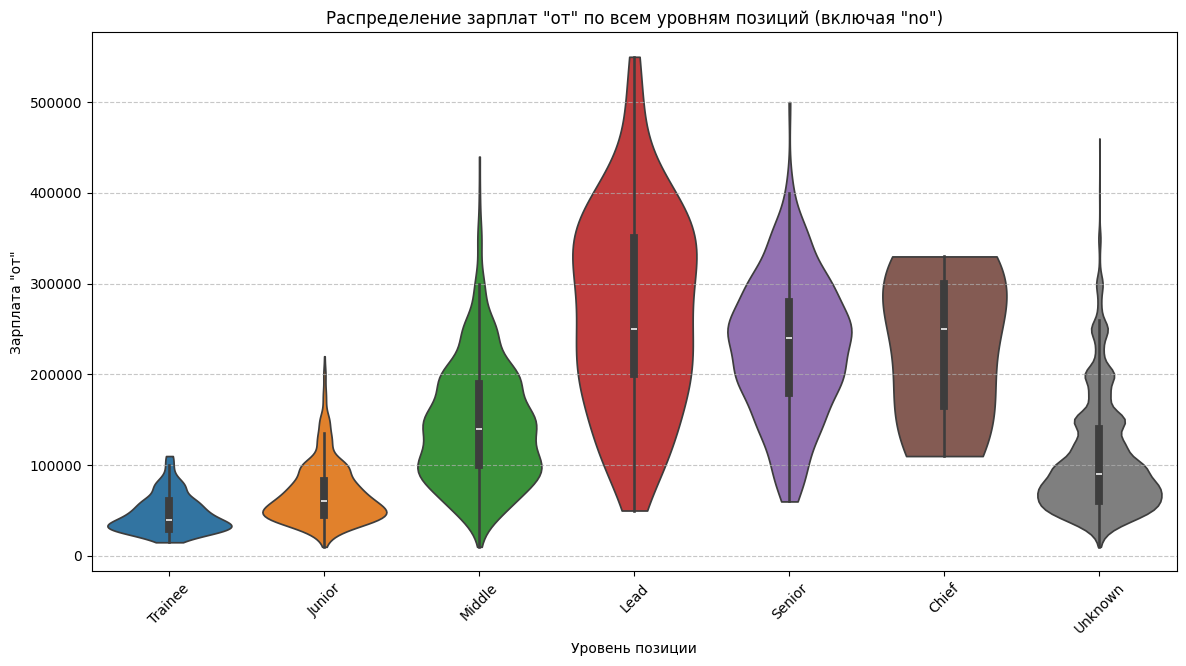

count           mean            std       min       25%       50%  \
level                                                                          
Trainee    178.0   46349.471910   20422.797323   15000.0   30000.0   40000.0   
Junior     726.0   68705.918733   32616.286065   10000.0   45000.0   60000.0   
Middle     659.0  144281.253414   65317.151086   10000.0  100000.0  140000.0   
Lead        76.0  270130.065789  108622.154126   50000.0  200000.0  250000.0   
Senior     258.0  229420.934109   75572.762426   60000.0  180000.0  240000.0   
Chief        7.0  231428.571429   85132.949248  110000.0  165000.0  250000.0   
Unknown  13071.0  107736.049193   61860.332961   10000.0   60000.0   90000.0   

              75%       max  
level                        
Trainee   60000.0  110000.0  
Junior    82500.0  220000.0  
Middle   189827.5  440000.0  
Lead     350000.0  550000.0  
Senior   280000.0  500000.0  
Chief    300000.0  330000.0  
Unknown  140000.0  460000.0

C:\Users\Aero-PC\AppData\Local\Temp\ipykernel_8844\4012837835.py:46: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




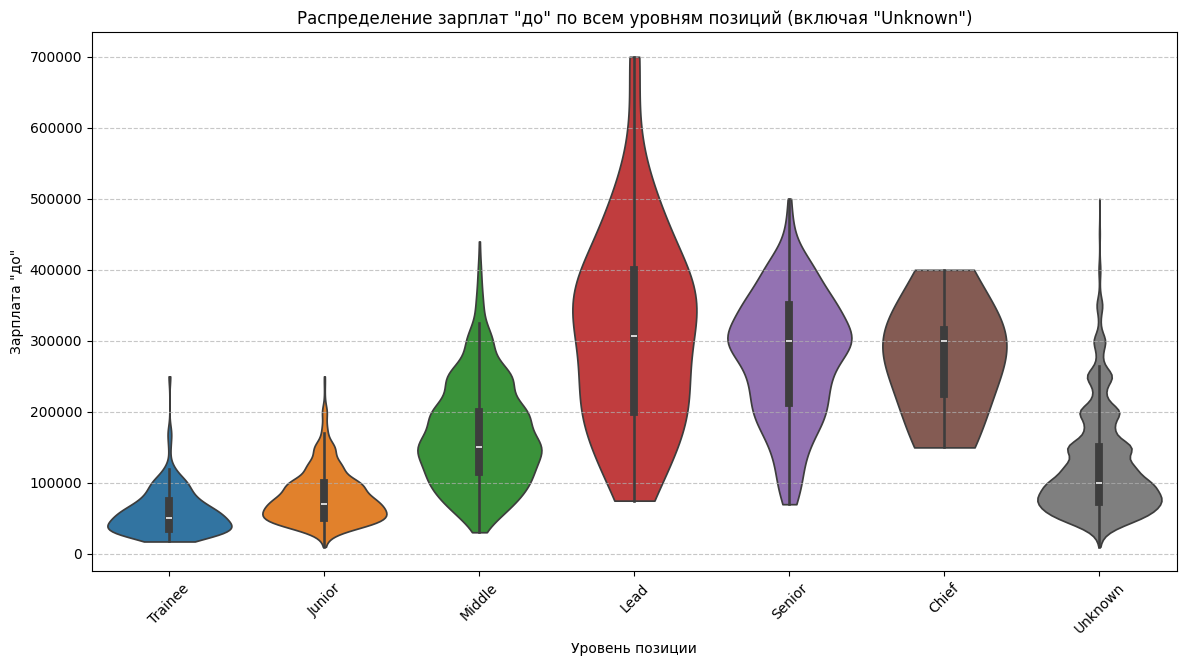

count           mean            std       min       25%       50%  \
level                                                                          
Trainee    178.0   58199.898876   31655.649901   17500.0   35000.0   50000.0   
Junior     726.0   80421.949036   36262.895676   10000.0   50000.0   70000.0   
Middle     659.0  167981.314112   72074.865284   30500.0  115000.0  150000.0   
Lead        76.0  312431.947368  136909.385976   75000.0  200000.0  307500.0   
Senior     258.0  277687.988372   86096.050592   70000.0  212500.0  300000.0   
Chief        7.0  275714.285714   83438.029470  150000.0  225000.0  300000.0   
Unknown  13071.0  124733.129447   70749.743301   10000.0   73000.0  100000.0   

              75%       max  
level                        
Trainee   75000.0  250000.0  
Junior   100000.0  250000.0  
Middle   200000.0  440000.0  
Lead     400000.0  700000.0  
Senior   350000.0  500000.0  
Chief    315000.0  400000.0  
Unknown  150000.0  500000.0

In [398]:
# Для зарплат "от"
stats_from = plot_salary_from_distribution(df)
display(stats_from)

# Для зарплат "до" 
stats_to = plot_salary_to_distribution(df)
display(stats_to)

In [399]:
# Попробуем избавиться от высоких з/п с level no

# начнем с salary from norm

# junior
mask = (df['level'] == 'no') & (df['salary to norm'] > 300000)
df[mask]

Empty DataFrame
Columns: [position, date, vacancy, company, city, experience, employment, schedule, salary from, salary to, currency, skills, url, ID, country, industry, text, period of pay, level, responsibilities, requirements, education, benefits, contacts, contact, experience level, skills_llm, skills_new, skills_list, skills_clean, skills_clean_norm, skills_count, vacancy_norm, vacancy_info, is_it, vacancy it, experience_norm, region, salary from norm, salary to norm, level_copy]
Index: []

[0 rows x 41 columns]

In [400]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14980 entries, 1110 to 20203
Data columns (total 41 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   position           14980 non-null  object 
 1   date               14980 non-null  object 
 2   vacancy            14980 non-null  object 
 3   company            14980 non-null  object 
 4   city               14980 non-null  object 
 5   experience         14980 non-null  object 
 6   employment         14980 non-null  object 
 7   schedule           14980 non-null  object 
 8   salary from        14980 non-null  float64
 9   salary to          14980 non-null  float64
 10  currency           14973 non-null  object 
 11  skills             14980 non-null  object 
 12  url                14980 non-null  object 
 13  ID                 14980 non-null  float64
 14  country            14980 non-null  object 
 15  industry           14980 non-null  object 
 16  text               14980

In [401]:
df['schedule'].value_counts()

schedule
Полный день         10764
Удаленная работа     3447
Сменный график        555
Гибкий график         189
Вахтовый метод         25
Name: count, dtype: int64

In [402]:
#df.to_csv('data/stage_3_df_to_model.csv', index=False)

##### 3.4. Region

In [403]:
df[df['country'] == 'Россия']['city'].value_counts()

city
Москва                             4858
Санкт-Петербург                    1988
Екатеринбург                        515
Новосибирск                         429
Казань                              399
                                   ... 
Волчанск (Свердловская область)       1
Карпинск                              1
Голицыно  (Московская область)        1
Удомля                                1
Тара                                  1
Name: count, Length: 380, dtype: int64

In [404]:
df['country'].value_counts()

country
Россия     14975
Украина        5
Name: count, dtype: int64

In [405]:
df_ru = df[(df['country'] == 'Россия')]

In [406]:
#df_ru.to_csv('data/stage_3_df_ru_region_skills_new_to_model_2.csv', index=False)

### 4. Vacancy clustering

In [407]:
df = df_ru

In [408]:
df['vacancy it'].nunique()

6944

In [409]:
from IPython.display import display, HTML
display(HTML(df['vacancy it'].value_counts().head(100).to_frame().to_html()))

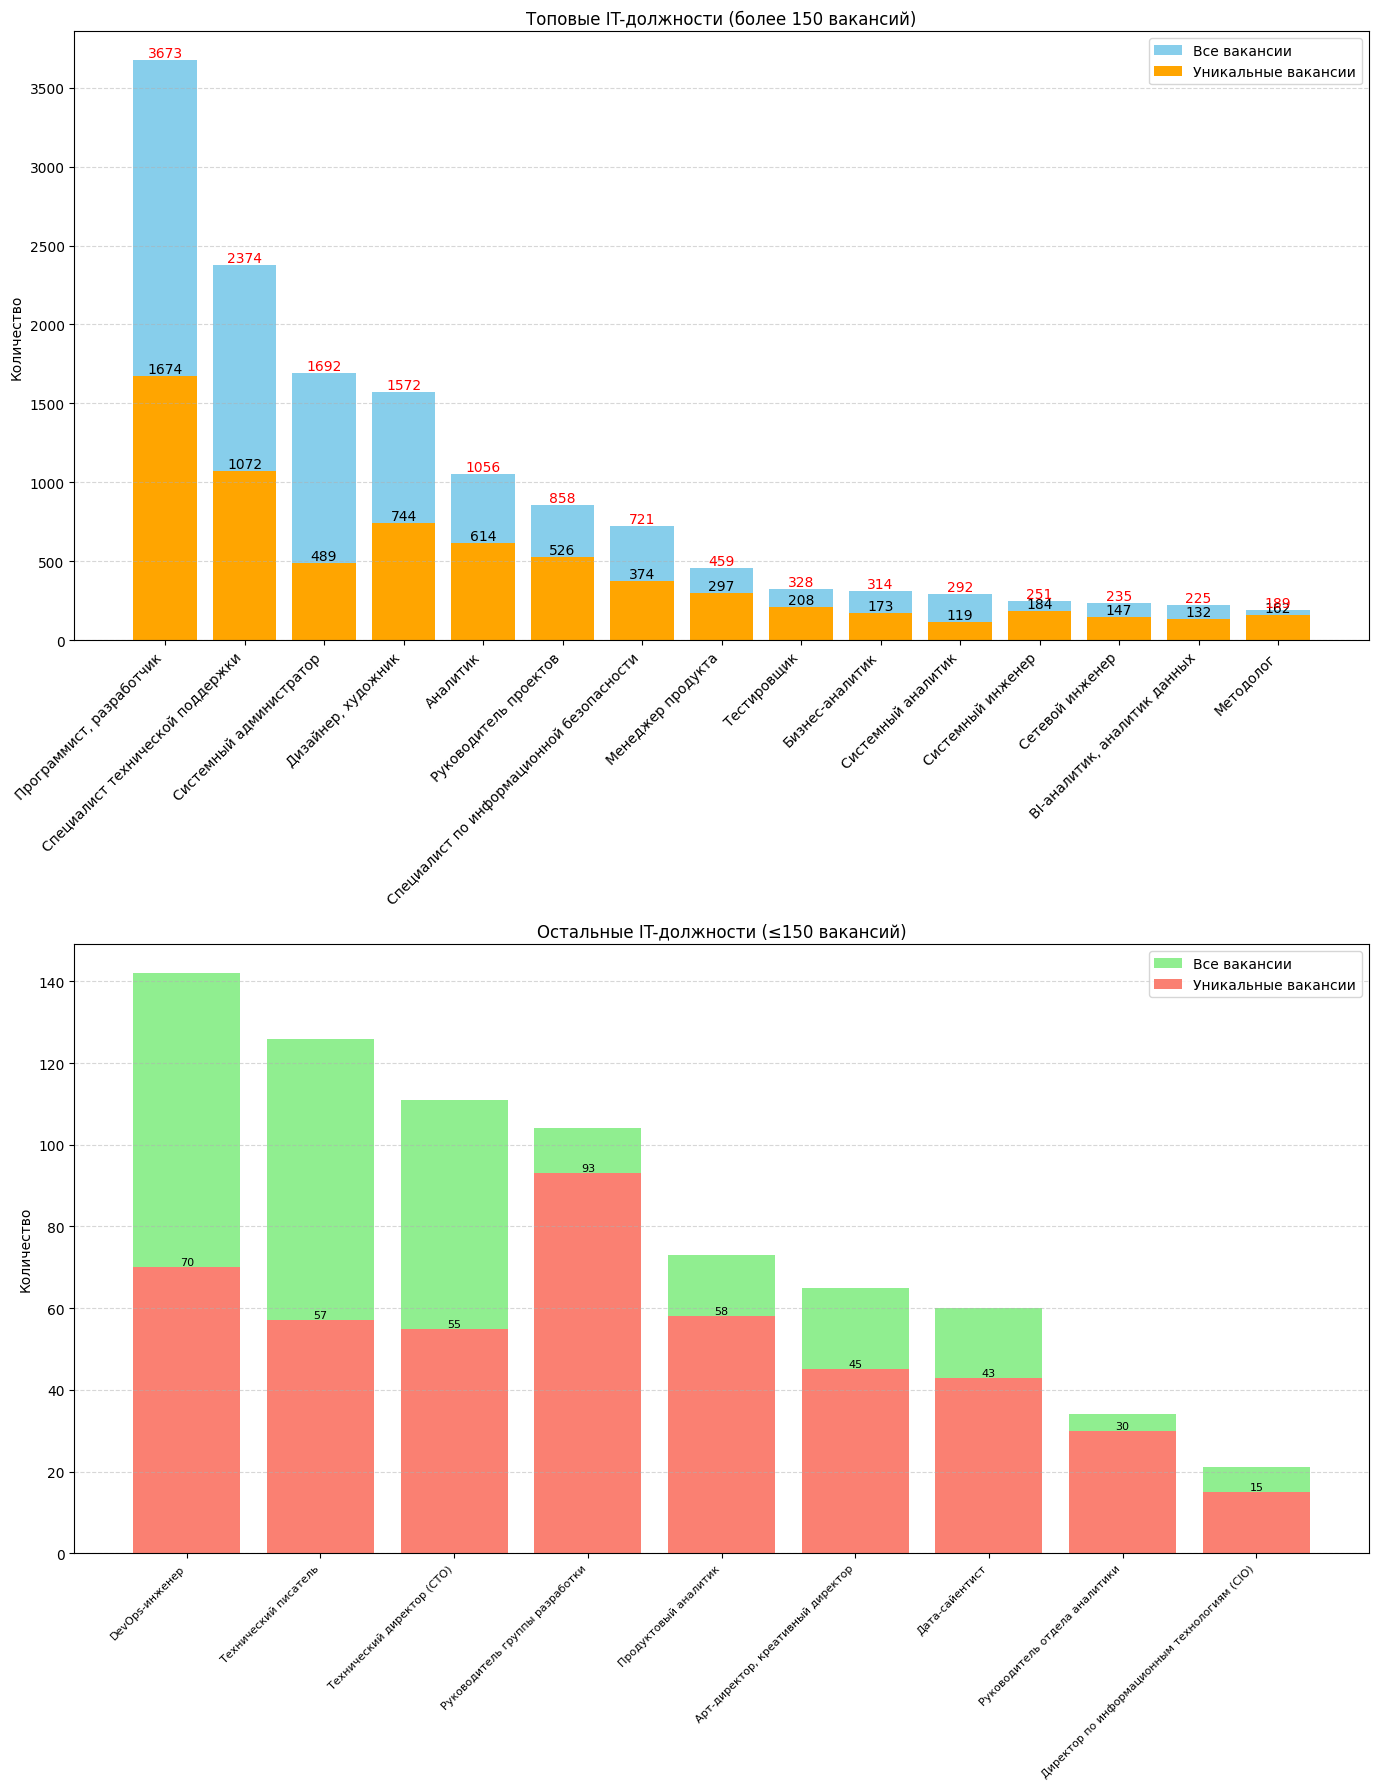

In [410]:
# Группировка данных
grouped = df.groupby('position')['vacancy it'].agg(['nunique', 'count']).sort_values('count', ascending=False)

# Разделение данных на две группы
top_positions = grouped[grouped['count'] > 150]
other_positions = grouped[grouped['count'] <= 150]

# Настройка стиля графиков
plt.figure(figsize=(14, 18))

# --- График 1: Топовые должности (>150 вакансий) ---
plt.subplot(2, 1, 1)
bars = plt.bar(top_positions.index, top_positions['count'], color='skyblue', label='Все вакансии')
plt.bar(top_positions.index, top_positions['nunique'], color='orange', label='Уникальные вакансии')

# Добавляем подписи значений
for bar, uniq, total in zip(bars, top_positions['nunique'], top_positions['count']):
    plt.text(bar.get_x() + bar.get_width()/2, uniq, f"{uniq}", ha='center', va='bottom', color='black')
    plt.text(bar.get_x() + bar.get_width()/2, total, f"{total}", ha='center', va='bottom', color='red')

plt.title('Топовые IT-должности (более 150 вакансий)')
plt.ylabel('Количество')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)

# --- График 2: Остальные должности (≤150 вакансий) ---
plt.subplot(2, 1, 2)
bars = plt.bar(other_positions.index, other_positions['count'], color='lightgreen', label='Все вакансии')
plt.bar(other_positions.index, other_positions['nunique'], color='salmon', label='Уникальные вакансии')

# Подписи значений (только для уникальных, если их мало)
for bar, uniq in zip(bars, other_positions['nunique']):
    if uniq > 0:  # Чтобы не загромождать график
        plt.text(bar.get_x() + bar.get_width()/2, uniq, f"{uniq}", ha='center', va='bottom', fontsize=8)

plt.title('Остальные IT-должности (≤150 вакансий)')
plt.ylabel('Количество')
plt.xticks(rotation=45, ha='right', fontsize=8)  # Уменьшаем шрифт, если много позиций
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [411]:
df_llm = pd.read_csv('df_vac_checked_stage_3.csv')

In [412]:
# Создаем новый столбец, сначала копируя значения из df['vacancy it']
df['vacancy_norm_llm_check_1'] = df['vacancy it']

# Обновляем только те строки, где ID совпадают с df_llm
mask = df['ID'].isin(df_llm['ID'])
df.loc[mask, 'vacancy_norm_llm_check_1'] = df_llm.loc[df_llm['ID'].isin(df['ID']), 'vacancy_norm_llm_check_1'].values

In [413]:
df['vacancy_norm_llm_check_1'].nunique()

4539

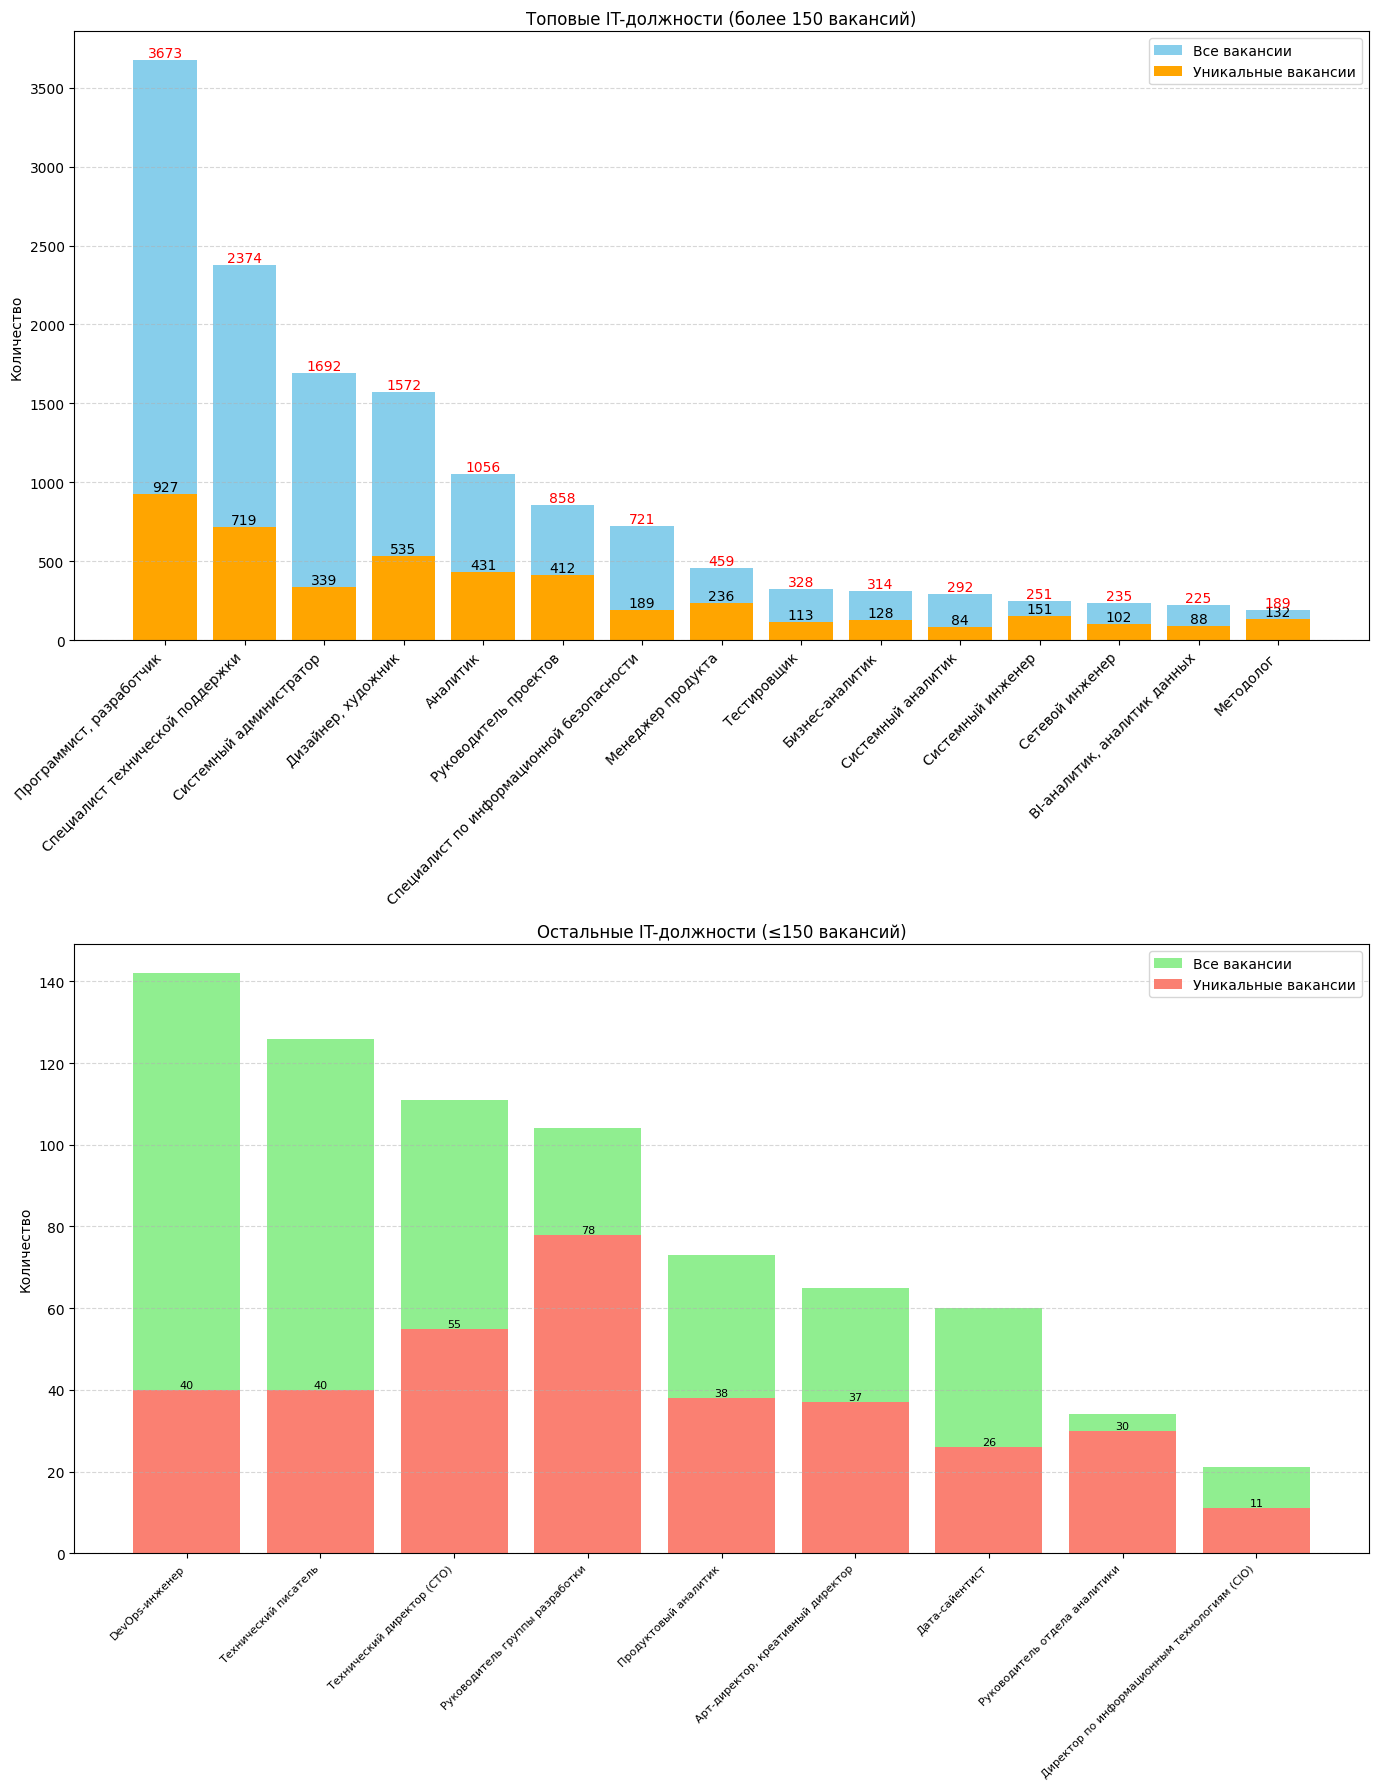

In [414]:
# Группировка данных
grouped = df.groupby('position')['vacancy_norm_llm_check_1'].agg(['nunique', 'count']).sort_values('count', ascending=False)

# Разделение данных на две группы
top_positions = grouped[grouped['count'] > 150]
other_positions = grouped[grouped['count'] <= 150]

# Настройка стиля графиков
plt.figure(figsize=(14, 18))

# --- График 1: Топовые должности (>150 вакансий) ---
plt.subplot(2, 1, 1)
bars = plt.bar(top_positions.index, top_positions['count'], color='skyblue', label='Все вакансии')
plt.bar(top_positions.index, top_positions['nunique'], color='orange', label='Уникальные вакансии')

# Добавляем подписи значений
for bar, uniq, total in zip(bars, top_positions['nunique'], top_positions['count']):
    plt.text(bar.get_x() + bar.get_width()/2, uniq, f"{uniq}", ha='center', va='bottom', color='black')
    plt.text(bar.get_x() + bar.get_width()/2, total, f"{total}", ha='center', va='bottom', color='red')

plt.title('Топовые IT-должности (более 150 вакансий)')
plt.ylabel('Количество')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)

# --- График 2: Остальные должности (≤150 вакансий) ---
plt.subplot(2, 1, 2)
bars = plt.bar(other_positions.index, other_positions['count'], color='lightgreen', label='Все вакансии')
plt.bar(other_positions.index, other_positions['nunique'], color='salmon', label='Уникальные вакансии')

# Подписи значений (только для уникальных, если их мало)
for bar, uniq in zip(bars, other_positions['nunique']):
    if uniq > 0:  # Чтобы не загромождать график
        plt.text(bar.get_x() + bar.get_width()/2, uniq, f"{uniq}", ha='center', va='bottom', fontsize=8)

plt.title('Остальные IT-должности (≤150 вакансий)')
plt.ylabel('Количество')
plt.xticks(rotation=45, ha='right', fontsize=8)  # Уменьшаем шрифт, если много позиций
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

#### 3.4 Skills

In [415]:
# Статистика по position
stats = df.groupby('position').agg(
    total_rows=('position', 'count'),  # Общее количество строк
    vacancy_count=('vacancy it', 'nunique'),  # Количество уникальных вакансий
    unique_skills=('skills_clean_norm', lambda x: x.explode().nunique())  # Уникальные навыки
).sort_values('total_rows', ascending=False)

# Настройки отображения
with pd.option_context('display.max_rows', None,
                      'display.float_format', '{:.0f}'.format):
    display(stats)

total_rows  vacancy_count  \
position                                                                  
Программист, разработчик                            3673           1674   
Специалист технической поддержки                    2374           1072   
Системный администратор                             1692            489   
Дизайнер, художник                                  1572            744   
Аналитик                                            1056            614   
Руководитель проектов                                858            526   
Специалист по информационной безопасности            721            374   
Менеджер продукта                                    459            297   
Тестировщик                                          328            208   
Бизнес-аналитик                                      314            173   
Системный аналитик                                   292            119   
Системный инженер                                    251            184   
Сетевой инженер                                      235            147   
BI-аналитик, аналитик данных                         225            132   
Методолог                                            189            162   
DevOps-инженер                                       142             70   
Технический писатель                                 126             57   
Технический директор (CTO)                           111             55   
Руководитель группы разработки                       104             93   
Продуктовый аналитик                                  73             58   
Арт-директор, креативный директор                     65             45   
Дата-сайентист                                        60             43   
Руководитель отдела аналитики                         34             30   
Директор по информационным технологиям (CIO)          21             15   

                                              unique_skills  
position                                                     
Программист, разработчик                              10798  
Специалист технической поддержки                       7351  
Системный администратор                                7293  
Дизайнер, художник                                     3116  
Аналитик                                               3221  
Руководитель проектов                                  3313  
Специалист по информационной безопасности              3509  
Менеджер продукта                                      2177  
Тестировщик                                            1510  
Бизнес-аналитик                                        1353  
Системный аналитик                                     1500  
Системный инженер                                      1593  
Сетевой инженер                                        1371  
BI-аналитик, аналитик данных                            791  
Методолог                                               958  
DevOps-инженер                                          812  
Технический писатель                                    580  
Технический директор (CTO)                              650  
Руководитель группы разработки                          670  
Продуктовый аналитик                                    431  
Арт-директор, креативный директор                       339  
Дата-сайентист                                          345  
Руководитель отдела аналитики                           189  
Директор по информационным технологиям (CIO)            161

In [416]:
#df_llm = pd.read_csv('df_vac_checked_stage_3')

In [417]:
top_positions = stats.head(25).reset_index()

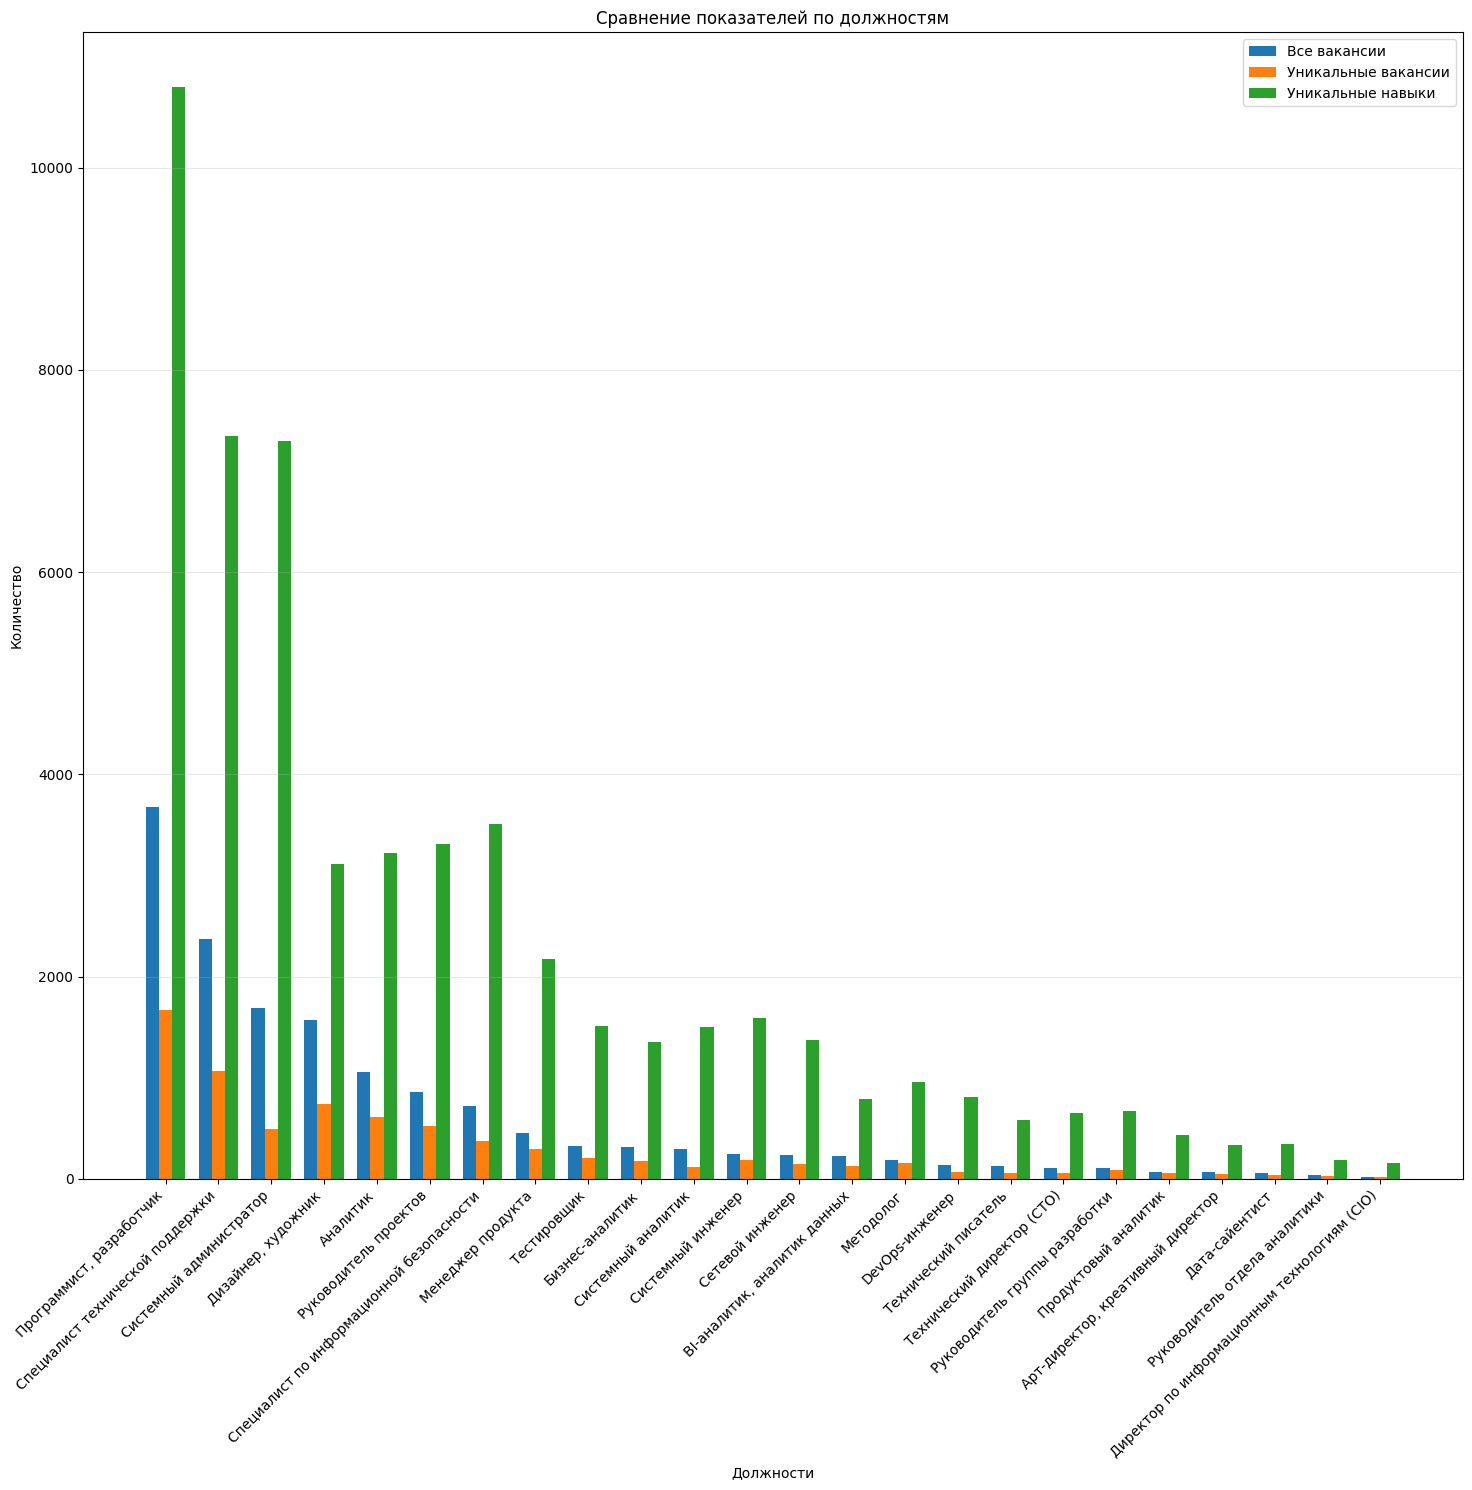

In [418]:
x = range(len(top_positions))
width = 0.25
plt.figure(figsize=(15, 15))
plt.bar(x, top_positions['total_rows'], width, label='Все вакансии')
plt.bar([i + width for i in x], top_positions['vacancy_count'], width, label='Уникальные вакансии')
plt.bar([i + 2*width for i in x], top_positions['unique_skills'], width, label='Уникальные навыки')

plt.title('Сравнение показателей по должностям')
plt.xlabel('Должности')
plt.ylabel('Количество')
plt.xticks([i + width for i in x], top_positions['position'], rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [419]:
def get_top_skills_by_position(df, position_name, feature, top_n=None):
    """
    Возвращает список навыков для указанной должности, отсортированный по частоте встречаемости
    
    Параметры:
    ----------
    df : DataFrame
        Исходный датафрейм с вакансиями
    position_name : str
        Название должности для фильтрации (например, 'Data Scientist')
    top_n : int, optional
        Количество возвращаемых навыков (по умолчанию - все)
    
    Возвращает:
    -----------
    Series
        Серия с навыками и их частотой, отсортированная по убыванию
    """
    # Фильтруем по должности и "разворачиваем" списки навыков
    skills_series = df[df['position'] == position_name][feature].explode()
    
    # Считаем частотность и сортируем
    skills_counts = skills_series.value_counts()
    
    # Возвращаем либо топ-N, либо все навыки
    return skills_counts.head(top_n) if top_n else skills_counts

In [ ]:
py_dev_skills = get_top_skills_by_position(df, 'Дата-сайентист', 'skills_clean_norm', top_n=345
                                           )
display(HTML(py_dev_skills.to_frame().to_html()))


In [421]:
all_skills = flatten_skills(df['skills_clean_norm'])
unique_skills_count = len(set(all_skills))
display(unique_skills_count)

41658

In [422]:


from rapidfuzz import fuzz, process
from tqdm import tqdm
import re

def split_compound_skill(skill):
    """
    Улучшенное разбиение составных навыков с сохранением структуры
    """
    # Если есть явные разделители с перечислением технологий
    if any(sep in skill for sep in [', ', ' / ', '; ']):
        # Разбиваем по разделителям, сохраняя основную категорию
        parts = re.split(r'(, | / |; )', skill)
        # Основная категория - часть до первого разделителя
        main_part = parts[0].strip()
        # Технологии - все остальные части
        techs = [p.strip() for p in parts[2::2] if p.strip()]
        return main_part, techs
    return skill, []


def is_multi_word_skill(skill):
    """
    Проверяет, является ли навык сложным (состоит из нескольких слов ИЛИ содержит важные спецсимволы)
    с учетом особенностей формулировок
    """
    normalized = normalize_skill_for_matching(skill)
    
    # Считаем навык сложным если:
    # 1. Содержит дефис/подчеркивание/точку (кроме разделителей)
    if re.search(r'[-\_.](?![-\_])', normalized):
        return True
    # 2. Явно состоит из нескольких слов
    if len(normalized.split()) > 1:
        return True
    # 3. Содержит CamelCase (кириллица или латиница)
    if re.search(r'([А-ЯЁA-Z][а-яёa-z])', skill):  # Проверяем оригинальный регистр
        return True
    return False
    
    
def normalize_skill_for_matching(skill):
    """
    Безопасная нормализация для сравнения навыков:
    - Сохраняет оригинальные пробелы внутри названия
    - Сохраняет специальные символы (дефисы, точки) внутри названия
    - Удаляет только разделители (/,) используемые для перечисления
    """
    skill = skill.strip().lower()
    # Заменяем только явные разделители с пробелами вокруг
    skill = re.sub(r'\s*[/,]\s*', ' ', skill)
    # Удаляем только лишние пробелы (но сохраняем оригинальные между словами)
    skill = re.sub(r'(\s){2,}', r'\1', skill)
    return skill

def find_skill_synonyms(position_skills, threshold=85):
    """
    Улучшенная версия с обработкой составных навыков
    """
    all_skills = [skill for skills_list in position_skills for skill in skills_list]
    if not all_skills:
        return {}

    skill_counts = Counter(all_skills)
    unique_skills = list(skill_counts.keys())
    
    synonyms = {}
    used_skills = set()

    # Сначала обрабатываем составные навыки
    for skill in tqdm(unique_skills, desc="Processing skills"):
        if skill in used_skills:
            continue
            
        main_part, techs = split_compound_skill(skill)
        
        # Для составных навыков ищем совпадения по основной части
        if techs:
            best_match = None
            best_score = 0
            
            for candidate in unique_skills:
                if candidate == skill or candidate in used_skills:
                    continue
                    
                cand_main, _ = split_compound_skill(candidate)
                score = fuzz.token_set_ratio(
                    normalize_skill_for_matching(main_part),
                    normalize_skill_for_matching(cand_main)
                )
                
                if score > best_score and score >= threshold:
                    best_score = score
                    best_match = candidate
            
            if best_match:
                synonyms.setdefault(best_match, []).append(skill)
                used_skills.add(skill)
            else:
                synonyms[skill] = []
                used_skills.add(skill)
        else:
            # Обычные навыки обрабатываем как раньше
            matches = process.extract(
                normalize_skill_for_matching(skill),
                [normalize_skill_for_matching(s) for s in unique_skills 
                 if s != skill and s not in used_skills],
                scorer=fuzz.token_set_ratio,
                limit=1
            )
            
            if matches and matches[0][1] >= threshold:
                best_match_norm = matches[0][0]
                original_match = next(s for s in unique_skills 
                                    if normalize_skill_for_matching(s) == best_match_norm 
                                    and s not in used_skills)
                synonyms.setdefault(original_match, []).append(skill)
                used_skills.add(skill)
            else:
                synonyms[skill] = []
                used_skills.add(skill)

    return synonyms

def process_skills_group(position_group):
    """Обработка группы с дополнительными проверками"""
    if 'skills_clean_norm' not in position_group.columns:
        position_group['skills_processed'] = position_group.get('skills_clean_norm', None)
        return position_group
    
    try:
        position_skills = position_group['skills_clean_norm'].tolist()
        skill_synonyms = find_skill_synonyms(position_skills)
        
        synonym_to_main = {}
        for main_skill, syns in skill_synonyms.items():
            for syn in syns:
                synonym_to_main[syn] = main_skill
            synonym_to_main[main_skill] = main_skill
        
        def replace_skills(skills_list):
            if not isinstance(skills_list, list):
                return skills_list
                
            replaced = []
            for skill in skills_list:
                if not isinstance(skill, str):
                    continue
                replaced.append(synonym_to_main.get(skill, skill))
            
            # Удаляем дубликаты
            seen = set()
            return [x for x in replaced if not (x in seen or seen.add(x))]
        
        position_group['skills_processed'] = position_group['skills_clean_norm'].apply(replace_skills)
    except Exception as e:
        print(f"Error processing group: {e}")
        position_group['skills_processed'] = position_group['skills_clean_norm']
    
    return position_group

def replace_skills(skills_list, synonym_to_main):
    """
    Улучшенная замена навыков с обработкой составных
    """
    replaced = []
    for skill in skills_list:
        if not isinstance(skill, str):
            continue
            
        main_part, techs = split_compound_skill(skill)
        
        if techs:
            # Обрабатываем составной навык
            new_main = synonym_to_main.get(main_part, main_part)
            # Объединяем технологии, удаляем дубли
            unique_techs = list(dict.fromkeys(
                synonym_to_main.get(t, t) for t in techs
            ))
            # Собираем обратно в строку
            if len(unique_techs) > 0:
                replaced_skill = f"{new_main} / {' / '.join(unique_techs)}"
            else:
                replaced_skill = new_main
        else:
            # Обычный навык
            replaced_skill = synonym_to_main.get(skill, skill)
        
        replaced.append(replaced_skill)
    
    # Удаляем дубликаты с сохранением порядка
    seen = set()
    return [x for x in replaced if not (x in seen or seen.add(x))]

In [423]:
def process_skills_pipeline(df):
    """Финальный пайплайн с защитой сложных навыков"""
    processed_df = df.copy()
    
    # Применяем обработку только если в skills_clean_norm есть данные
    if 'skills_clean_norm' in processed_df.columns:
        processed_df = processed_df.groupby('position', group_keys=False).apply(process_skills_group)
    
    return processed_df

In [424]:
#df_copy = df.copy()

In [ ]:
stop

In [425]:
processed_df = process_skills_pipeline(df)

Processing skills: 100%|██████████| 580/580 [00:01<00:00, 525.84it/s]
C:\Users\Aero-PC\AppData\Local\Temp\ipykernel_8844\2686836096.py:7: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [426]:
# Статистика по position
stats = processed_df.groupby('position').agg(
    total_rows=('position', 'count'),  # Общее количество строк
    vacancy_count=('vacancy it', 'nunique'),  # Количество уникальных вакансий
    unique_skills=('skills_processed', lambda x: x.explode().nunique())  # Уникальные навыки
).sort_values('total_rows', ascending=False)

# Настройки отображения
with pd.option_context('display.max_rows', None,
                      'display.float_format', '{:.0f}'.format):
    display(stats)

total_rows  vacancy_count  \
position                                                                  
Программист, разработчик                            3673           1674   
Специалист технической поддержки                    2374           1072   
Системный администратор                             1692            489   
Дизайнер, художник                                  1572            744   
Аналитик                                            1056            614   
Руководитель проектов                                858            526   
Специалист по информационной безопасности            721            374   
Менеджер продукта                                    459            297   
Тестировщик                                          328            208   
Бизнес-аналитик                                      314            173   
Системный аналитик                                   292            119   
Системный инженер                                    251            184   
Сетевой инженер                                      235            147   
BI-аналитик, аналитик данных                         225            132   
Методолог                                            189            162   
DevOps-инженер                                       142             70   
Технический писатель                                 126             57   
Технический директор (CTO)                           111             55   
Руководитель группы разработки                       104             93   
Продуктовый аналитик                                  73             58   
Арт-директор, креативный директор                     65             45   
Дата-сайентист                                        60             43   
Руководитель отдела аналитики                         34             30   
Директор по информационным технологиям (CIO)          21             15   

                                              unique_skills  
position                                                     
Программист, разработчик                               8426  
Специалист технической поддержки                       5502  
Системный администратор                                5166  
Дизайнер, художник                                     2721  
Аналитик                                               2675  
Руководитель проектов                                  2728  
Специалист по информационной безопасности              2715  
Менеджер продукта                                      1884  
Тестировщик                                            1262  
Бизнес-аналитик                                        1212  
Системный аналитик                                     1308  
Системный инженер                                      1304  
Сетевой инженер                                        1183  
BI-аналитик, аналитик данных                            715  
Методолог                                               883  
DevOps-инженер                                          754  
Технический писатель                                    509  
Технический директор (CTO)                              601  
Руководитель группы разработки                          626  
Продуктовый аналитик                                    407  
Арт-директор, креативный директор                       329  
Дата-сайентист                                          326  
Руководитель отдела аналитики                           183  
Директор по информационным технологиям (CIO)            156

In [427]:
top_positions = stats.head(25).reset_index()

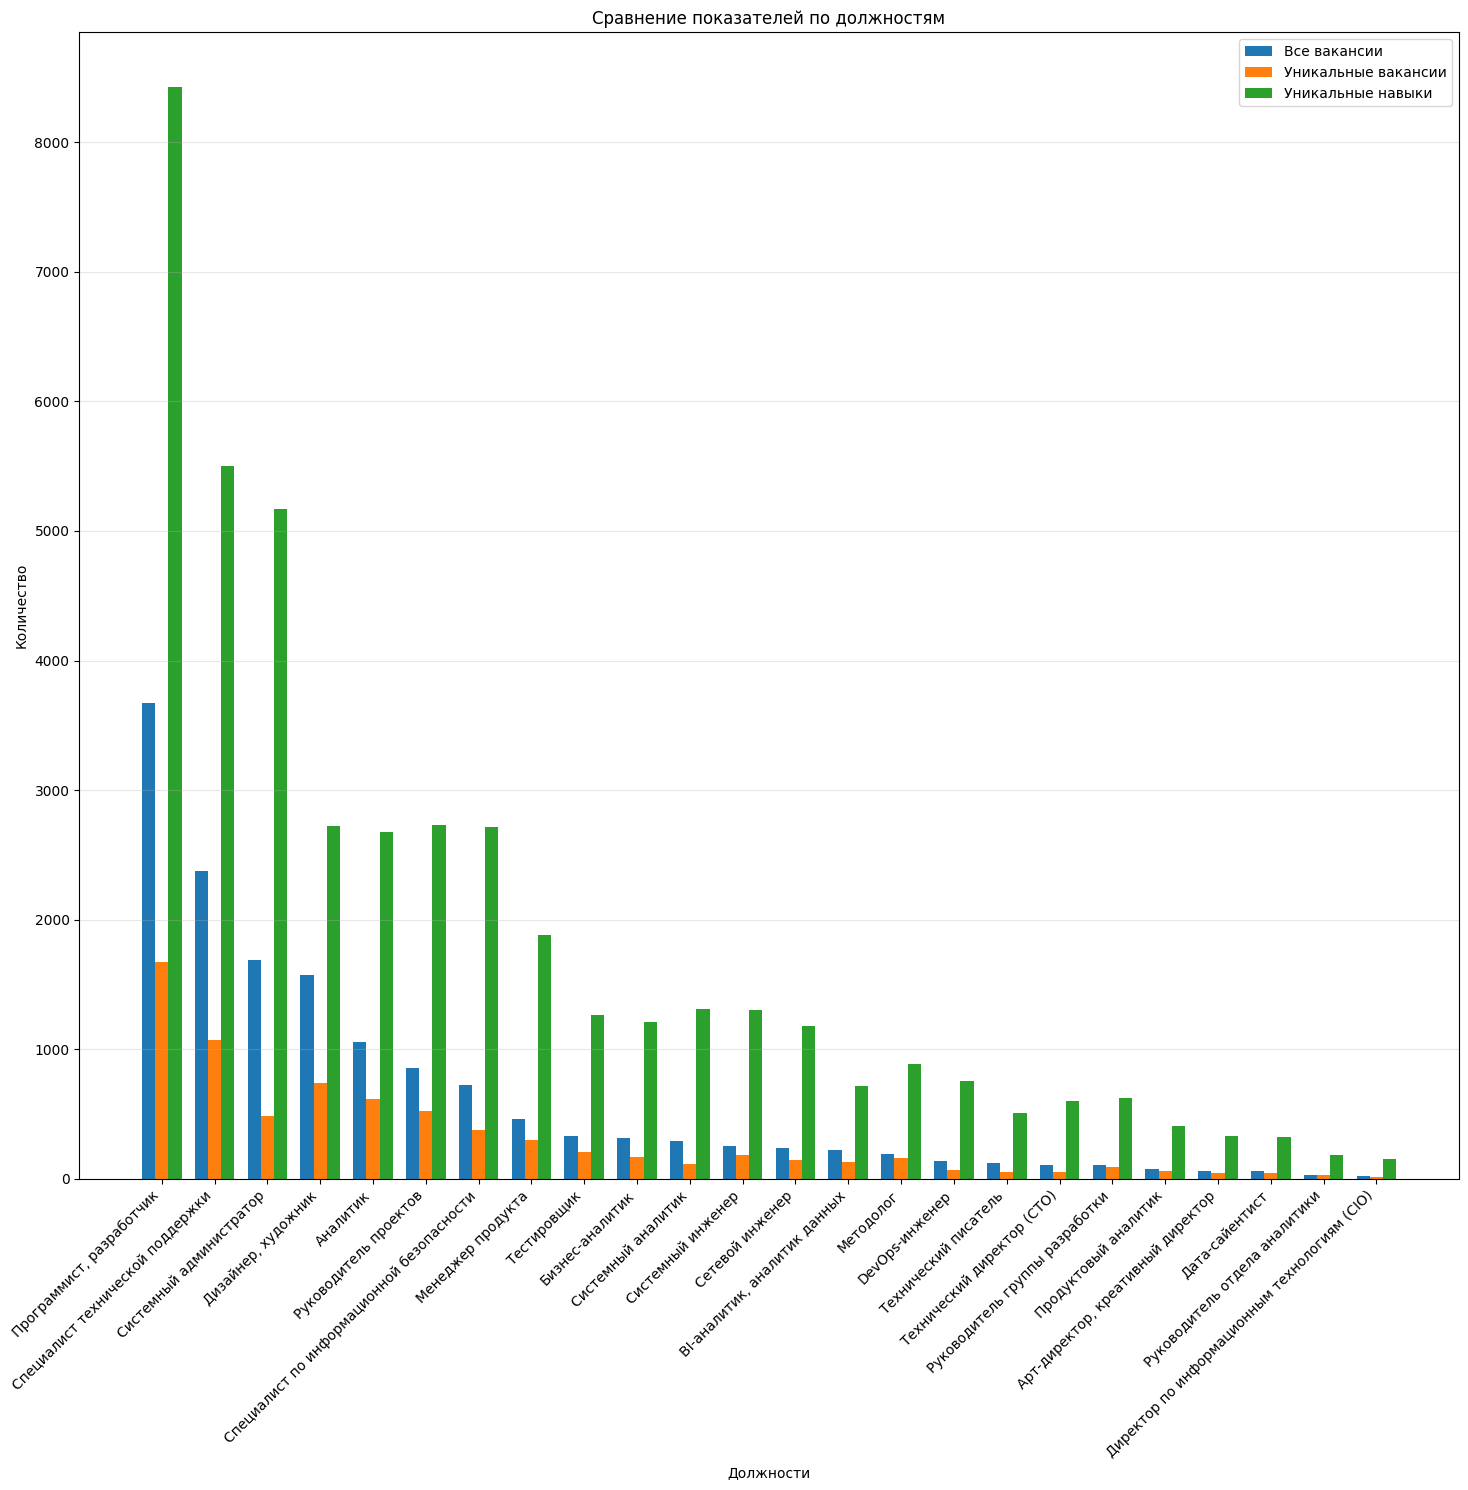

In [428]:
x = range(len(top_positions))
width = 0.25
plt.figure(figsize=(15, 15))
plt.bar(x, top_positions['total_rows'], width, label='Все вакансии')
plt.bar([i + width for i in x], top_positions['vacancy_count'], width, label='Уникальные вакансии')
plt.bar([i + 2*width for i in x], top_positions['unique_skills'], width, label='Уникальные навыки')

plt.title('Сравнение показателей по должностям')
plt.xlabel('Должности')
plt.ylabel('Количество')
plt.xticks([i + width for i in x], top_positions['position'], rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [429]:
all_skills = flatten_skills(processed_df['skills_processed'])
unique_skills_count = len(set(all_skills))
display(unique_skills_count)

34445

In [430]:
df['skills_processed'] = processed_df['skills_processed']

In [ ]:
py_dev_skills = get_top_skills_by_position(processed_df, 'Дата-сайентист','skills_processed', top_n=345
                                           )
display(HTML(py_dev_skills.to_frame().to_html()))


In [432]:
#df.to_csv('data/stage_3_df_cluster_vac_to_model_4.csv', index=False)

In [433]:
df['skills_count'] = df['skills_processed'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# Считаем распределение
skills_dist = df['skills_count'].value_counts().sort_index().reset_index()
skills_dist.columns = ['Количество навыков', 'Число вакансий']

# Строим интерактивный график
fig = px.bar(
    skills_dist,
    x='Количество навыков',
    y='Число вакансий',
    title='Распределение количества навыков в вакансиях',
    labels={'Количество навыков': 'Число навыков в вакансии', 'Число вакансий': 'Количество вакансий'},
    text='Число вакансий',
    color='Количество навыков',
    color_continuous_scale='Viridis'
)

# Добавляем среднюю линию
mean_val = df['skills_count'].mean()
fig.add_shape(
    type="line",
    x0=mean_val, y0=0,
    x1=mean_val, y1=skills_dist['Число вакансий'].max(),
    line=dict(color="red", width=2, dash="dot")
)

fig.add_annotation(
    x=mean_val,
    y=skills_dist['Число вакансий'].max(),
    text=f"Среднее: {mean_val:.1f}",
    showarrow=True,
    arrowhead=1,
    ax=-40
)

# Настройки отображения
fig.update_traces(texttemplate='%{text}', textposition='outside')
fig.update_layout(
    hovermode="x",
    xaxis=dict(tickmode='linear'),
    coloraxis_showscale=False
)

fig.show()

In [434]:
#df['skills_count'] = df['skills_clean_norm'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# Считаем распределение
skills_dist = df['skills_count'].value_counts().sort_index().reset_index()
skills_dist.columns = ['Количество навыков', 'Число вакансий']

# Строим интерактивный график
fig = px.bar(
    skills_dist,
    x='Количество навыков',
    y='Число вакансий',
    title='Распределение количества навыков в вакансиях',
    labels={'Количество навыков': 'Число навыков в вакансии', 'Число вакансий': 'Количество вакансий'},
    text='Число вакансий',
    color='Количество навыков',
    color_continuous_scale='Viridis'
)

# Добавляем среднюю линию
mean_val = df['skills_count'].mean()
fig.add_shape(
    type="line",
    x0=mean_val, y0=0,
    x1=mean_val, y1=skills_dist['Число вакансий'].max(),
    line=dict(color="red", width=2, dash="dot")
)

fig.add_annotation(
    x=mean_val,
    y=skills_dist['Число вакансий'].max(),
    text=f"Среднее: {mean_val:.1f}",
    showarrow=True,
    arrowhead=1,
    ax=-40
)

# Настройки отображения
fig.update_traces(texttemplate='%{text}', textposition='outside')
fig.update_layout(
    hovermode="x",
    xaxis=dict(tickmode='linear'),
    coloraxis_showscale=False
)

fig.show()

In [435]:
top_positions = df['position'].value_counts().index.tolist()
df_top_positions = df[df['position'].isin(top_positions)]

fig = px.histogram(
    df_top_positions,
    x='skills_count',
    facet_col='position',
    facet_col_wrap=3,
    title='Distribution of Skills Count by Position',
    labels={'skills_count': 'Number of Skills'},
    color='position',
    nbins=15,
    height=2000,  # Увеличил высоту общего графика
    width=1000,
    facet_row_spacing=0.02  # Уменьшил расстояние между строками
)

# Добавление вертикальных линий и аннотаций
for i, position in enumerate(top_positions, 1):
    subplot_df = df_top_positions[df_top_positions['position'] == position]
    median_val = subplot_df['skills_count'].median()
    
    # Добавим вертикальную линию
    fig.add_vline(
        x=median_val,
        line_dash="dot",
        line_color="red",
        opacity=0.7,
        row=(i - 1) // 3 + 1,
        col=(i - 1) % 3 + 1
    )

    # Добавим подпись к среднему значению
    fig.add_annotation(
        x=median_val,
        y=0.85,
        yref='paper',
        text=f'Median: {median_val:.1f}',
        showarrow=False,
        font=dict(color='red'),
        row=(i - 1) // 3 + 1,
        col=(i - 1) % 3 + 1
    )

# Финальные настройки
fig.update_layout(
    showlegend=False,
    hovermode="x",
    xaxis_title='Number of Skills',
    yaxis_title='Number of Vacancies',
    margin=dict(t=80, b=40)
)

fig.update_xaxes(matches=None)
fig.show()

##### В ручную доработаем Skills

In [446]:
# Итоговый словарь: {position: {skill: count}}
position_skills_freq = {}

# Группируем по позициям и обрабатываем навыки
for position, group in df.groupby('position'):
    # Создаем плоский список всех навыков для позиции
    all_skills = [skill for sublist in group['skills_clean_norm'] for skill in sublist]
    # Считаем частотность через Counter
    skills_freq = Counter(all_skills)
    # Записываем в итоговый словарь
    position_skills_freq[position] = dict(skills_freq)
    


# Преобразуем словарь в DataFrame
df_freq = pd.DataFrame.from_dict(position_skills_freq, orient='index').stack().reset_index()
df_freq.columns = ['position', 'skill', 'frequency']
# Сортируем и фильтруем топ-200
df_top_200 = df_freq.sort_values(['position', 'frequency'], ascending=[True, False])
df_top_200 = df_top_200.groupby('position').head(200)

# Сохраняем в Excel с разными листами
with pd.ExcelWriter('top_200_skills_by_position.xlsx') as writer:
    for position, group in df_top_200.groupby('position'):
        # Убираем колонку position, так как она теперь в названии листа
        group.drop('position', axis=1).to_excel(
            writer,
            sheet_name=position[:31],  # Ограничение длины имени листа в Excel
            index=False
        )

In [ ]:
# Фильтруем записи:
analyst_with_sales = df[
    (df['position'] == 'Дизайнер, художник') &  # Выбираем только позицию "Аналитик"
    (df['skills_clean_norm'].apply(lambda skills: 'Продажи' in skills))  # Проверяем наличие "Продажи" в списке skills_clean_norm
][['vacancy','vacancy it', 'skills_clean_norm', 'text']]  # Выбираем нужные колонки

# Выводим результат
display(analyst_with_sales)  # Красивое отображение в Jupyter Notebook


display(HTML(analyst_with_sales.to_html()))

In [ ]:
# Фильтруем записи:
analyst_with_sales = df[
    (df['position'] == 'Аналитик') &  # Выбираем только позицию "Аналитик"
    (df['skills_clean_norm'].apply(lambda skills: 'Продажи' in skills))  # Проверяем наличие "Продажи" в списке skills_clean_norm
][['vacancy','vacancy it', 'skills_clean_norm', 'text']]  # Выбираем нужные колонки

# Выводим результат
display(analyst_with_sales)  # Красивое отображение в Jupyter Notebook






In [ ]:
# после ручной первичной проработки

# Загружаем Excel-файл с каноническими скиллами
canon_file = 'top_200_skills_by_position_checked.xlsx'
canon_data = pd.read_excel(canon_file, sheet_name=None)

# Создаём маппинг: укороченное имя листа (до 31 символа) -> полное название позиции
unique_positions = df['position'].unique()
sheet_to_position = {pos[:31]: pos for pos in unique_positions}

# Создаём словарь: {position: {skill: [canon(s)]}}
position_skill_to_canon = defaultdict(dict)

for sheet_name, sheet_df in canon_data.items():
    position_full = sheet_to_position.get(sheet_name)
    if not position_full:
        continue  # пропускаем несопоставленные
    for _, row in sheet_df.iterrows():
        skill = row['skill']
        canon = row.get('canon')
        if pd.notna(canon):
            canon_skills = [s.strip() for s in str(canon).split(',') if s.strip()]
            position_skill_to_canon[position_full][skill] = canon_skills

# Функция замены скиллов по канонам
def map_skills(row):
    position = row['position']
    skills = row['skills_clean_norm']
    canon_map = position_skill_to_canon.get(position, {})
    new_skills = []
    for skill in skills:
        if skill in canon_map:
            new_skills.extend(canon_map[skill])
        else:
            new_skills.append(skill)
    return list(set(new_skills))  # убираем дубли

# Применяем замену
df['skills_manu'] = df.apply(map_skills, axis=1)

# Проверим, есть ли слова 'Продажи' после замены
def contains_prodagi(skills):
    return any('продажи' in s.lower() for s in skills)

# Количество строк с 'Продажи' до фильтрации
num_with_prodagi = df['skills_manu'].apply(contains_prodagi).sum()

# Фильтруем строки без 'Продажи'
df_filtered = df[~df['skills_manu'].apply(contains_prodagi)].copy()
num_filtered = len(df) - len(df_filtered)

num_with_prodagi





np.int64(216)

In [467]:
all_skills = flatten_skills(df['skills_manu'])
unique_skills_count = len(set(all_skills))
display(unique_skills_count)

41617

In [468]:
df['skills_manu']

1110     [PostgreSQL, SQLite, Python, Проектирование и ...
1111            [HTML CSS, Python, SQL, JS, Pandas, Scipy]
1112     [Системы управления проектами, Power Pivot, Py...
1113     [Системы управления проектами, Power Pivot, Py...
1114     [Системы управления проектами, Power Pivot, Py...
                               ...                        
20193    [Консультирование клиентов, Подбор оборудовани...
20196    [Работа с ПК, Разработка технических схем, MS ...
20197    [Сетевые протоколы TCP/IP, Системы мониторинга...
20200    [Управленческий учёт 1С, CRM 1C, RESTapi, Reac...
20203    [AutoCad/NanoCad, Градостроительный кодекс Рос...
Name: skills_manu, Length: 14975, dtype: object

In [469]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14975 entries, 1110 to 20203
Data columns (total 46 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   position                  14975 non-null  object 
 1   date                      14975 non-null  object 
 2   vacancy                   14975 non-null  object 
 3   company                   14975 non-null  object 
 4   city                      14975 non-null  object 
 5   experience                14975 non-null  object 
 6   employment                14975 non-null  object 
 7   schedule                  14975 non-null  object 
 8   salary from               14975 non-null  float64
 9   salary to                 14975 non-null  float64
 10  currency                  14968 non-null  object 
 11  skills                    14975 non-null  object 
 12  url                       14975 non-null  object 
 13  ID                        14975 non-null  float64
 14  country 

In [470]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14759 entries, 1110 to 20203
Data columns (total 46 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   position                  14759 non-null  object 
 1   date                      14759 non-null  object 
 2   vacancy                   14759 non-null  object 
 3   company                   14759 non-null  object 
 4   city                      14759 non-null  object 
 5   experience                14759 non-null  object 
 6   employment                14759 non-null  object 
 7   schedule                  14759 non-null  object 
 8   salary from               14759 non-null  float64
 9   salary to                 14759 non-null  float64
 10  currency                  14752 non-null  object 
 11  skills                    14759 non-null  object 
 12  url                       14759 non-null  object 
 13  ID                        14759 non-null  float64
 14  country 

In [471]:
df_copy= df.copy()

In [472]:
df = df_filtered

In [488]:
# отсечем по топ - 100 скилам 
def filtered_skills_top_n(df_train_result, n):
    """
    Фильтрует навыки, оставляя только N наиболее популярных навыков для каждой позиции.
    
    :param df_skills_filtered: Входящий DataFrame с колонками 'position' и 'skills'.
    :param n: Число наиболее популярных навыков, которое нужно оставить.
    :return: Отфильтрованный DataFrame с сокращённым списком навыков.
    """
    
    result_df = df_train_result.copy()
    #display(result_df['skills'])
    # Перебираем каждую уникальную должность
    for pos in result_df['position'].unique():
        # Маска для выбора строк с нужной должностью
        mask = result_df['position'] == pos
        
        # Собираем все навыки в один большой список
        skills_lists = result_df.loc[mask, 'skills_manu']
        all_skills = [skill for sublist in skills_lists for skill in sublist]
        
        # Считаем частоту появления каждого навыка
        skill_counts = Counter(all_skills)
        
        # Берём топ-n навыков
        top_n_skills = set([skill for skill, _ in skill_counts.most_common(n)])
        
        # Применяем фильтр к списку навыков
        result_df.loc[mask, 'skills_manu'] = skills_lists.apply(
            lambda skill_list: [s for s in skill_list if s in top_n_skills]
        )
        #display(result_df['skills'])
    return result_df

In [489]:
df_skills_100 = filtered_skills_top_n(df.copy(), 100)

    # Удаляем строки с пустыми списками skills
df_skills_100 = df_skills_100[df_skills_100['skills_manu'].apply(lambda x: len(x) > 0)]

In [490]:
df_skills_100.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11242 entries, 1110 to 20200
Data columns (total 46 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   position                  11242 non-null  object 
 1   date                      11242 non-null  object 
 2   vacancy                   11242 non-null  object 
 3   company                   11242 non-null  object 
 4   city                      11242 non-null  object 
 5   experience                11242 non-null  object 
 6   employment                11242 non-null  object 
 7   schedule                  11242 non-null  object 
 8   salary from               11242 non-null  float64
 9   salary to                 11242 non-null  float64
 10  currency                  11236 non-null  object 
 11  skills                    11242 non-null  object 
 12  url                       11242 non-null  object 
 13  ID                        11242 non-null  float64
 14  country 

In [491]:
# Статистика по position
stats_100s = df_skills_100.groupby('position').agg(
    total_rows=('position', 'count'),  # Общее количество строк
    vacancy_count=('vacancy it', 'nunique'),  # Количество уникальных вакансий
    unique_skills=('skills_manu', lambda x: x.explode().nunique())  # Уникальные навыки
).sort_values('total_rows', ascending=False)

# Настройки отображения
with pd.option_context('display.max_rows', None,
                      'display.float_format', '{:.0f}'.format):
    display(stats_100s)

total_rows  vacancy_count  \
position                                                                  
Программист, разработчик                            2973           1402   
Специалист технической поддержки                    1609            753   
Дизайнер, художник                                  1288            588   
Системный администратор                             1191            337   
Аналитик                                             836            486   
Руководитель проектов                                628            394   
Специалист по информационной безопасности            391            211   
Менеджер продукта                                    314            197   
Тестировщик                                          268            170   
Бизнес-аналитик                                      267            145   
Системный аналитик                                   232             90   
BI-аналитик, аналитик данных                         203            120   
Сетевой инженер                                      154             92   
Системный инженер                                    153            114   
Методолог                                            130            111   
DevOps-инженер                                       125             56   
Технический писатель                                 104             46   
Руководитель группы разработки                        84             75   
Технический директор (CTO)                            75             39   
Продуктовый аналитик                                  60             48   
Дата-сайентист                                        57             40   
Арт-директор, креативный директор                     53             35   
Руководитель отдела аналитики                         29             25   
Директор по информационным технологиям (CIO)          18             13   

                                              unique_skills  
position                                                     
Программист, разработчик                                100  
Специалист технической поддержки                        100  
Дизайнер, художник                                      100  
Системный администратор                                 100  
Аналитик                                                100  
Руководитель проектов                                   100  
Специалист по информационной безопасности               100  
Менеджер продукта                                       100  
Тестировщик                                             100  
Бизнес-аналитик                                         100  
Системный аналитик                                      100  
BI-аналитик, аналитик данных                            100  
Сетевой инженер                                         100  
Системный инженер                                       100  
Методолог                                               100  
DevOps-инженер                                          100  
Технический писатель                                    100  
Руководитель группы разработки                          100  
Технический директор (CTO)                              100  
Продуктовый аналитик                                    100  
Дата-сайентист                                          100  
Арт-директор, креативный директор                       100  
Руководитель отдела аналитики                           100  
Директор по информационным технологиям (CIO)            100

In [493]:
# Оставим позиции с > 50 строк 

# Считаем количество вхождений каждой должности
position_counts = df_skills_100['position'].value_counts()

# Получаем список должностей, которые встречаются более 50 раз
positions_50 = position_counts[position_counts > 50].index

# Фильтруем исходный DataFrame, оставляя только строки с популярными должностями
df_filtered_100s_50p = df_skills_100[df_skills_100['position'].isin(positions_50)]

In [496]:
df_filtered_100s_50p.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11195 entries, 1110 to 20200
Data columns (total 46 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   position                  11195 non-null  object 
 1   date                      11195 non-null  object 
 2   vacancy                   11195 non-null  object 
 3   company                   11195 non-null  object 
 4   city                      11195 non-null  object 
 5   experience                11195 non-null  object 
 6   employment                11195 non-null  object 
 7   schedule                  11195 non-null  object 
 8   salary from               11195 non-null  float64
 9   salary to                 11195 non-null  float64
 10  currency                  11189 non-null  object 
 11  skills                    11195 non-null  object 
 12  url                       11195 non-null  object 
 13  ID                        11195 non-null  float64
 14  country 

##### В ручную доработаеи  Vacancy

In [509]:
# Словарь для хранения: {position: DataFrame с топ-100 вакансиями и скиллами}
position_top_vacancies = {}

# Проход по каждой позиции
for position, group in df_filtered_100s_50p.groupby('position'):
    # Группируем по vacancy_it и считаем количество
    vacancy_counts = group['vacancy_norm_llm_check_1'].value_counts()  #.head(100)

    # Получаем топ-100 вакансий
    top_vacancies = vacancy_counts.index.tolist()

    # Фильтруем строки, где vacancy_it входит в топ-100
    filtered_rows = group[group['vacancy_norm_llm_check_1'].isin(top_vacancies)].copy()

    # Группируем по вакансии и собираем уникальные скиллы (без повторов внутри строки)
    vacancy_skills = (
        filtered_rows.groupby('vacancy_norm_llm_check_1')['skills_manu']
        .apply(lambda lists: list(set(skill for sublist in lists for skill in sublist)))
        .reset_index()
    )

    # Добавляем частотность
    vacancy_skills['frequency'] = vacancy_skills['vacancy_norm_llm_check_1'].map(vacancy_counts.to_dict())

    # Переименуем колонку
    vacancy_skills.rename(columns={'skills_manu': 'skills'}, inplace=True)

    # Сохраняем в итоговый словарь
    position_top_vacancies[position] = vacancy_skills[['vacancy_norm_llm_check_1', 'skills', 'frequency']]

# Сохраняем всё в Excel
with pd.ExcelWriter('vacancies_with_skills.xlsx') as writer:
    for position, df_pos in position_top_vacancies.items():
        sheet_name = position[:31]  # Excel ограничение
        df_pos.to_excel(writer, sheet_name=sheet_name, index=False)

In [516]:
# после установки канонов в ручную 

# Загружаем Excel-файл с канонами вакансий
canon_file = 'vacancies_with_skills.xlsx'
canon_data = pd.read_excel(canon_file, sheet_name=None)

# Сопоставление: короткое имя листа -> полное название позиции
unique_positions = df_filtered_100s_50p['position'].unique()
sheet_to_position = {pos[:31]: pos for pos in unique_positions}

# Создаём маппинг: {position: {vacancy: canon}}
position_vacancy_to_canon = defaultdict(dict)

for sheet_name, sheet_df in canon_data.items():
    position_full = sheet_to_position.get(sheet_name)
    if not position_full:
        continue
    for _, row in sheet_df.iterrows():
        vac = row['vacancy_norm_llm_check_1']
        canon = row.get('canon')
        if pd.notna(canon):
            position_vacancy_to_canon[position_full][vac] = canon

# Функция замены вакансии
def map_vacancy(row):
    position = row['position']
    vacancy = row['vacancy_norm_llm_check_1']
    canon_map = position_vacancy_to_canon.get(position, {})
    return canon_map.get(vacancy, vacancy)  # если нет канона — вернуть исходную

# Применяем
df_filtered_100s_50p['vacancy_manu'] = df_filtered_100s_50p.apply(map_vacancy, axis=1)

In [512]:
df_filtered_100s_50p.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11195 entries, 1110 to 20200
Data columns (total 47 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   position                  11195 non-null  object 
 1   date                      11195 non-null  object 
 2   vacancy                   11195 non-null  object 
 3   company                   11195 non-null  object 
 4   city                      11195 non-null  object 
 5   experience                11195 non-null  object 
 6   employment                11195 non-null  object 
 7   schedule                  11195 non-null  object 
 8   salary from               11195 non-null  float64
 9   salary to                 11195 non-null  float64
 10  currency                  11189 non-null  object 
 11  skills                    11195 non-null  object 
 12  url                       11195 non-null  object 
 13  ID                        11195 non-null  float64
 14  country 

In [517]:
# Статистика по position
stats_100s = df_filtered_100s_50p.groupby('position').agg(
    total_rows=('position', 'count'),  # Общее количество строк
    vacancy_count=('vacancy_manu', 'nunique'),  # Количество уникальных вакансий
    unique_skills=('skills_manu', lambda x: x.explode().nunique())  # Уникальные навыки
).sort_values('total_rows', ascending=False)

# Настройки отображения
with pd.option_context('display.max_rows', None,
                      'display.float_format', '{:.0f}'.format):
    display(stats_100s)

total_rows  vacancy_count  \
position                                                               
Программист, разработчик                         2973             68   
Специалист технической поддержки                 1609             16   
Дизайнер, художник                               1288             16   
Системный администратор                          1191             13   
Аналитик                                          836             18   
Руководитель проектов                             628             12   
Специалист по информационной безопасности         391              9   
Менеджер продукта                                 314             10   
Тестировщик                                       268             13   
Бизнес-аналитик                                   267             13   
Системный аналитик                                232              9   
BI-аналитик, аналитик данных                      203             18   
Сетевой инженер                                   154              8   
Системный инженер                                 153             16   
Методолог                                         130             11   
DevOps-инженер                                    125              7   
Технический писатель                              104              5   
Руководитель группы разработки                     84              9   
Технический директор (CTO)                         75              5   
Продуктовый аналитик                               60             32   
Дата-сайентист                                     57              3   
Арт-директор, креативный директор                  53              4   

                                           unique_skills  
position                                                  
Программист, разработчик                             100  
Специалист технической поддержки                     100  
Дизайнер, художник                                   100  
Системный администратор                              100  
Аналитик                                             100  
Руководитель проектов                                100  
Специалист по информационной безопасности            100  
Менеджер продукта                                    100  
Тестировщик                                          100  
Бизнес-аналитик                                      100  
Системный аналитик                                   100  
BI-аналитик, аналитик данных                         100  
Сетевой инженер                                      100  
Системный инженер                                    100  
Методолог                                            100  
DevOps-инженер                                       100  
Технический писатель                                 100  
Руководитель группы разработки                       100  
Технический директор (CTO)                           100  
Продуктовый аналитик                                 100  
Дата-сайентист                                       100  
Арт-директор, креативный директор                    100

In [ ]:
#df_filtered_100s_50p.to_csv('data/stage_3_df_100s_50p_5.csv', index=False)

In [502]:
df_filtered_100s_50p['level'].value_counts()

level
Unknown    9627
Middle      576
Junior      552
Senior      228
Trainee     138
Lead         69
Chief         5
Name: count, dtype: int64

In [500]:
df_filtered_100s_50p[df_filtered_100s_50p['level'] == 'Unknown']['vacancy it']

1113                                    Аналитик данных
1115                                    Аналитик данных
1116     Главный специалист отдела системной экспертизы
1117                 Аналитик-разработчик по BI системе
1118                           Администратор приложений
                              ...                      
20181                             Инженер-проектировщик
20188                        Cпециалист по сертификации
20196                             Инженер-исследователь
20197                              Технический писатель
20200                              Технический писатель
Name: vacancy it, Length: 9627, dtype: object

In [504]:
def update_level_from_vacancy_it(df):
    df = df.copy()
    
    # Только строки, где уровень не распознан
    mask = df['level'] == 'Unknown'
    
    # Приводим к нижнему регистру и заменяем дефис на пробел
    vacancy_cleaned = df.loc[mask, 'vacancy it'].str.lower().str.replace('-', ' ', regex=False)

    def extract_level(text):
        if 'главный' in text:
            return 'Главный'
        elif 'старший' in text:
            return 'Старший'
        elif 'младший' in text:
            return 'Младший'
        elif 'стажер' in text or 'интерн' in text:
            return 'Trainee'
        else:
            return 'Unknown'

    df.loc[mask, 'level'] = vacancy_cleaned.apply(extract_level)
    return df

df_filtered_100s_50p = update_level_from_vacancy_it(df_filtered_100s_50p)

In [505]:
df_filtered_100s_50p['level'].value_counts()

level
Unknown    9357
Middle      576
Junior      552
Senior      228
Trainee     149
Главный     144
Старший     115
Lead         69
Chief         5
Name: count, dtype: int64

In [ ]:
#df_filtered_100s_50p.to_csv('data/stage_3_df_100s_50p_5.csv', index=False)

In [437]:
from pathlib import Path

# Создаем папку для результатов
output_dir = Path("vacancy_comparison")
output_dir.mkdir(exist_ok=True)

# Получаем список всех должностей, отсортированный по частоте
positions = df['position'].value_counts().index

for position in positions:
    try:
        print(f"\nАнализируем позицию: {position}")
        
        # Фильтруем данные по текущей должности
        position_df = df[df['position'] == position]
        
        # Получаем топ-30 вакансий из обоих столбцов
        top_it = position_df['vacancy it'].value_counts().head(30)
        top_llm = position_df['vacancy_norm_2'].value_counts().head(30)
        
        # Создаем сравнительную таблицу
        comparison_df = pd.DataFrame({
            'vacancy_it': top_it,
            'vacancy_norm_2': top_llm,
            'diff': top_it - top_llm
        }).fillna(0).astype({'vacancy_it': int, 'vacancy_norm_2': int, 'diff': int})
        
        # Сохраняем в Excel
        safe_position_name = "".join(x if x.isalnum() else "_" for x in position)
        excel_path = output_dir / f"{safe_position_name[:50]}_comparison.xlsx"
        comparison_df.to_excel(excel_path)
        
        # Автоматически определяем высоту фигуры в зависимости от количества строк
        num_rows = len(comparison_df)
        fig_height = max(6, num_rows * 0.25)  # минимум 6, иначе будет слишком сжато

        plt.figure(figsize=(15, fig_height))
        comparison_df[['vacancy_it', 'vacancy_norm_2']].sort_values('vacancy_it', ascending=False).plot(
            kind='barh', 
            color=['#1f77b4', '#ff7f0e'],
            alpha=0.7,
            figsize=(15, fig_height)
        )

        plt.title(f'Сравнение вакансий для: {position}\n', fontsize=14)
        plt.xlabel('Количество упоминаний', fontsize=12)
        plt.ylabel('Название вакансии', fontsize=12)
        plt.legend(['Оригинал (vacancy_it)', 'Нормализованный (vacancy_norm_2)'])
        plt.grid(axis='x', alpha=0.3)

        plt.yticks(fontsize=12)  # уменьшенный шрифт для подписей Y
        plt.tight_layout()
        
        # Сохраняем график
        plot_path = output_dir / f"{safe_position_name[:30]}_plot.png"
        plt.tight_layout()
        plt.savefig(plot_path, dpi=150, bbox_inches='tight')
        plt.close()
        
        print(f"Результаты сохранены в: {excel_path} и {plot_path}")
        
    except Exception as e:
        print(f"Ошибка при обработке позиции {position}: {str(e)}")

print("\nОбработка всех позиций завершена!")


Анализируем позицию: Программист, разработчик
Ошибка при обработке позиции Программист, разработчик: 'vacancy_norm_2'

Анализируем позицию: Специалист технической поддержки
Ошибка при обработке позиции Специалист технической поддержки: 'vacancy_norm_2'

Анализируем позицию: Системный администратор
Ошибка при обработке позиции Системный администратор: 'vacancy_norm_2'

Анализируем позицию: Дизайнер, художник
Ошибка при обработке позиции Дизайнер, художник: 'vacancy_norm_2'

Анализируем позицию: Аналитик
Ошибка при обработке позиции Аналитик: 'vacancy_norm_2'

Анализируем позицию: Руководитель проектов
Ошибка при обработке позиции Руководитель проектов: 'vacancy_norm_2'

Анализируем позицию: Специалист по информационной безопасности
Ошибка при обработке позиции Специалист по информационной безопасности: 'vacancy_norm_2'

Анализируем позицию: Менеджер продукта
Ошибка при обработке позиции Менеджер продукта: 'vacancy_norm_2'

Анализируем позицию: Тестировщик
Ошибка при обработке позиции Т

In [438]:
# Создаем новый столбец, сначала копируя значения из df['vacancy it']
df['vacancy_norm_1'] = df['vacancy it']

# Обновляем только те строки, где ID совпадают с df_llm
mask = df['ID'].isin(df_llm['ID'])
df.loc[mask, 'vacancy_norm_1'] = df_llm.loc[df_llm['ID'].isin(df['ID']), 'vacancy_norm_1'].values

In [440]:
#df.to_csv('data/stage_3_df_cluster_vac_to_model_4.csv', index=False)

In [441]:
grouped = df.groupby('position')

with pd.ExcelWriter('positions.xlsx') as writer:
    for name, group in grouped:
        group.head(30).to_excel(writer, sheet_name=str(name)[:31], index=False)

In [442]:

try:
    from rapidfuzz import fuzz
    use_rapidfuzz = True
except ImportError:
    import difflib
    use_rapidfuzz = False

# 1. Базовая текстовая нормализация
def normalize_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s-]', '', text)  # убрать спецсимволы кроме дефисов
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# 2. Функция схлопывания синонимов в одну каноническую форму
def canonicalize_group(group, threshold=85):
    texts = group['vacancy_norm_1'].tolist()
    norm_texts = [normalize_text(t) for t in texts]
    canon_map = {}
    used = set()

    for i, base in enumerate(norm_texts):
        if base in used:
            continue

        cluster = [texts[i]]
        used.add(base)

        for j in range(i + 1, len(norm_texts)):
            if norm_texts[j] in used:
                continue

            score = (
                fuzz.token_sort_ratio(base, norm_texts[j]) if use_rapidfuzz
                else difflib.SequenceMatcher(None, base, norm_texts[j]).ratio() * 100
            )

            if score >= threshold:
                cluster.append(texts[j])
                used.add(norm_texts[j])

        # каноническая форма — самая частотная или самая короткая
        canon = min(cluster, key=len)
        for variant in cluster:
            canon_map[variant] = canon

    group['vacancy_norm_2'] = group['vacancy_norm_1'].map(canon_map)
    return group

# 3. Главная функция
def reduce_vacancy_variants(df, text_col='vacancy_norm_1', group_col='position', threshold=85):
    df = df.copy()
    df = df.groupby(group_col, group_keys=False).apply(canonicalize_group, threshold=threshold)
    return df

In [443]:
df = reduce_vacancy_variants(df)

C:\Users\Aero-PC\AppData\Local\Temp\ipykernel_8844\1100645657.py:53: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [444]:
df['vacancy_norm_2'].value_counts()

vacancy_norm_2
Системный администратор                                                                            1070
Программист                                                                                         766
Специалист технической поддержки                                                                    676
Графический дизайнер                                                                                284
Инженер технической поддержки                                                                       249
                                                                                                   ... 
Специалист группы ИТ                                                                                  1
Инженер cлужбы информационных технологий и средств диспетчерского и технологического управления       1
Техник в отдел сопровождения                                                                          1
Специалист по обработке отзывов с сайта          

In [445]:
#df.to_csv('data/stage_3_df_cluster_vac_to_model_4.csv', index=False)